<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Предобработка" data-toc-modified-id="Предобработка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Предобработка</a></span><ul class="toc-item"><li><span><a href="#Данные-о-компаниях" data-toc-modified-id="Данные-о-компаниях-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Данные о компаниях</a></span></li><li><span><a href="#Данные-о-активностях" data-toc-modified-id="Данные-о-активностях-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Данные о активностях</a></span></li><li><span><a href="#Данные-о-платежах" data-toc-modified-id="Данные-о-платежах-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Данные о платежах</a></span></li><li><span><a href="#Данные-о-сотрудниках" data-toc-modified-id="Данные-о-сотрудниках-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Данные о сотрудниках</a></span></li></ul></li><li><span><a href="#Исследовательский-анализ" data-toc-modified-id="Исследовательский-анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследовательский анализ</a></span><ul class="toc-item"><li><span><a href="#Численность-компаний" data-toc-modified-id="Численность-компаний-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Численность компаний</a></span></li><li><span><a href="#Популярность-тарифов" data-toc-modified-id="Популярность-тарифов-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Популярность тарифов</a></span></li><li><span><a href="#Смена-тарифов" data-toc-modified-id="Смена-тарифов-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Смена тарифов</a></span></li><li><span><a href="#Активность-работы-клиентов-в-сервисе" data-toc-modified-id="Активность-работы-клиентов-в-сервисе-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Активность работы клиентов в сервисе</a></span></li><li><span><a href="#Пользователи" data-toc-modified-id="Пользователи-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Пользователи</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li></ul></div>

# Анализ клиентов облачного сервиса Gectaro


**Цель проекта**  
*Определить ключевые признаки для компаний(клиентов), наличие которых влияет на отмену подписки*

- проанализировать имеющиеся данные, 
- составить портреты наиболее типичных клиентов, 
- разобраться в причинах оттока клиентов, 
- предложить решения по их минимизации. 

**О Компании**  
gectaro – облачный сервис для автоматизации управления строительством и ремонтом.
Компания продает софт с платной подпиской в сегменте B2B (наиболее частый срок подписки 12-24 месяца), предназначенный для управления процессами в сфере строительства и ремонта.
Основная проблема – это уход из сервиса большого количества подписчиков и не продление подписки.
 
**Задачи**
1. Провести исследовательский анализ данных;
2. Сформулировать и проверить гипотезы, основываясь на имеющихся признаках;
3. Формулирование выводов по полученным результатам, подготовка презентации.

**Описание данных**  
Для работы представлено 4 файла с описанием компаний и их сотрудников:  
- роли, 
- количество работающих в системе, 
- количество совершенных действий по месяцам 
- прочая информация.

In [1]:
import pandas as pd
import re
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx
from dateutil.relativedelta import relativedelta

pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_columns')
plt.rc('figure', figsize=(15, 6))
pd.options.display.float_format = '{:,.2f}'.format

In [2]:
lcolors= ['#357aff','#ea5c5c','#9b51e0','#6cd289','#ffb800','#bec2c5']
palette = sns.color_palette(lcolors)
palette

[(0.20784313725490197, 0.47843137254901963, 1.0),
 (0.9176470588235294, 0.3607843137254902, 0.3607843137254902),
 (0.6078431372549019, 0.3176470588235294, 0.8784313725490196),
 (0.4235294117647059, 0.8235294117647058, 0.5372549019607843),
 (1.0, 0.7215686274509804, 0.0),
 (0.7450980392156863, 0.7607843137254902, 0.7725490196078432)]

In [3]:
# Удаляем неинформативные колонки Unnamed
def unnamed_drop(df):
    columns_to_drop = [column for column in df.columns if 'Unn' in column]
    df.drop(columns=columns_to_drop, inplace=True)

In [4]:
# функция сбора информации по датасетам
def show_stats(df):

    start_shape = df.shape
    mins, means, medians, maxs = [], [], [], []
    stats_df = pd.DataFrame(index=df.columns.tolist())
    stats_df['dtype'] = [df[col].dtypes for col in df.columns]
    stats_df['memory_usage'] = df.memory_usage(deep=True)
    stats_df['nans_count'] = df.isna().sum().tolist()
    stats_df['nans_ratio_%'] = (df.isna().mean() * 100).round(2)
    stats_df['uniques'] = [df[col].nunique() for col in df.columns]
    for col in df.columns:
        if df[col].dtypes in ['int64', 'int32', 'int16', 'int8', 'Int8', 'Int16', 'float']:
            mins.append(round(df[col].min(), 2))
            means.append(round(df[col].mean(), 2))
            medians.append(round(df[col].median(), 2))
            maxs.append(round(df[col].max(), 2))
        else:
            mins.append(np.nan)
            means.append(np.nan)
            medians.append(np.nan)
            maxs.append(np.nan)
    stats_df['min'], stats_df['mean'], stats_df['median'], stats_df['max'] = mins, means, medians, maxs
    def format_nan_to_empty(val):
        return '' if pd.isna(val) else val
    s_style = '\x1b[6;30;42m'
    e_style = '\x1b[0m'
    print('------------------------------------------')
    print(s_style + 'Основная информация по колонкам таблицы:' + e_style)
    print('Количество строк:', start_shape[0], \
          '\nКоличество колонок:', start_shape[1], \
          '\nОбщее потребление памяти датасетом: {:.2f} MB'.format(stats_df['memory_usage'].sum() / (1024 * 1024)))
    display(stats_df.style            
            .format('{:.2f}', subset=['nans_ratio_%', 'min', 'mean', 'median', 'max'])
            .format(format_nan_to_empty)
           .background_gradient(cmap='coolwarm', subset=['nans_ratio_%']))
    dubl_count = df.duplicated().sum()
    dubl_ratio = round(dubl_count / start_shape[0] * 100, 2)
    print('------------------------------------------')
    print(s_style +'Явные дубликаты:                         ' + e_style )
    print('Число явных дубликатов:', dubl_count, \
          '\nДоля явных дубликатов от всего датасета:', dubl_ratio, '%')
    print(s_style +'\nПервые 5 строк:                          ' + e_style )
    display(df.head(2))

In [5]:
companies = pd.read_csv('companies.csv')
activities = pd.read_csv('activities.csv')
billing = pd.read_csv('billing.csv')
people = pd.read_csv('people.csv')

In [6]:
#удалим во всех датастах колонки unnamed
for df in [companies, activities, billing, people]:
    unnamed_drop(df)

## Предобработка

### Данные о компаниях

In [7]:
show_stats(companies)

------------------------------------------
Основная информация по колонкам таблицы:
Количество строк: 723 
Количество колонок: 7 
Общее потребление памяти датасетом: 0.09 MB


,dtype,memory_usage,nans_count,nans_ratio_%,uniques,min,mean,median,max
id,int64,5784,0,0.0,723,1.0,4618.42,4430.0,9931.0
working_direction,object,59997,3,0.41,170,,,,
employer_count_interval,float64,5784,0,0.0,8,1.0,1.52,1.0,8.0
created_at,int64,5784,0,0.0,723,1548252051.0,1636150346.15,1634199208.0,1707310569.0
updated_at,int64,5784,0,0.0,514,1594046967.0,1680751872.55,1671444307.0,1710326664.0
billing_tariff_id,float64,5784,7,0.97,13,2.0,5.02,4.0,21.0
billing_is_over,bool,723,0,0.0,2,,,,


------------------------------------------
Явные дубликаты:                         
Число явных дубликатов: 0 
Доля явных дубликатов от всего датасета: 0.0 %

Первые 5 строк:                          


,id,working_direction,employer_count_interval,created_at,updated_at,billing_tariff_id,billing_is_over
0,514,-,1.00,1571316635,1670298314,4.00,True
1,383,Строительство,2.00,1564142565,1676550050,7.00,False


В данных есть незначитльные проуски(менее 1%) которые нужно удалить 
В колонках с данными о дате и времни нужно привести формат к читаемому, для дальнейшей работы
Колонка id содержит уникальные значения равные количеству строк 

In [8]:
#удалим пропуски
companies.dropna(inplace=True)

In [9]:
#справочник тарифов
d = {tuple([4,7,8,11,19]):'старт',
           tuple([2, 17]):'базовый',
           tuple([9, 20]):'бизнес',
   tuple([3, 10, 13, 21]):'профи',
    tuple([6]):6}

#создадим отдельную колонку с наименованием тарифов 
for key, value in d.items():
    companies.loc[companies.billing_tariff_id.isin(list(key)), 'billing_tariff'] = value

companies.billing_tariff.replace('nan', None, inplace=True)

In [10]:
companies.billing_tariff.value_counts()

billing_tariff
базовый    328
старт      306
бизнес      50
профи       23
6            6
Name: count, dtype: int64

In [11]:
#приведем формат даты
companies['created_at'] = pd.to_datetime(companies.created_at.apply(lambda x: datetime.utcfromtimestamp(x)))
companies['updated_at'] = pd.to_datetime(companies.updated_at.apply(lambda x: datetime.utcfromtimestamp(x)))

In [12]:
#посмотрим профиль дятельности компании
companies.working_direction.value_counts().head(6)

working_direction
-                            452
Строительство                 55
строительство                 10
Малоэтажное строительство      5
-строительство                 4
Строительство и ремонт         4
Name: count, dtype: int64

Больше половины данных имеют пропуск. Данная колонка мало информативна. Оставим ее без изменений.

In [13]:
#посмотрим данные о количестве сотрудников в компании
companies.employer_count_interval.value_counts()

employer_count_interval
1.00    491
2.00    144
3.00     46
4.00     14
5.00      9
8.00      4
7.00      3
6.00      2
Name: count, dtype: int64

In [14]:
#справочник количество сотрудников в компании
dict_people = {
1.0 : '1-4',
2.0 : '5-10',
3.0 : '11-20',
4.0 : '21-30',
5.0 : '31-50',
6.0 : '51-100',
7.0 : '101-200',
8.0 : '>201'
}

#заменим данные на категориальные 
companies.employer_count_interval = companies.employer_count_interval.replace(dict_people)

In [15]:
#посмотрим данные о количестве сотрудников в компании
companies.employer_count_interval.value_counts()

employer_count_interval
1-4        491
5-10       144
11-20       46
21-30       14
31-50        9
>201         4
101-200      3
51-100       2
Name: count, dtype: int64

остальные даные оставим как есть

In [16]:
#опредлим за какой период прелоставлены данные 
companies.created_at.apply(['min', 'max'])

min   2019-01-23 14:00:51
max   2024-02-07 12:56:09
Name: created_at, dtype: datetime64[ns]

In [17]:
companies.billing_is_over.value_counts()

billing_is_over
True     481
False    232
Name: count, dtype: int64

**Вывод:**
- Данные о компаниях предоставлены за период с 2019-01-23 по 2024-02-07
- Всего 723 компании
- В данных чаще встречаются компании с количеством сотрудников до 5 человек(491 раз), менее 10(144)
- В данных больше компаний с просрочнным статусом оплаты     

### Данные о активностях

In [18]:
show_stats(activities)

------------------------------------------
Основная информация по колонкам таблицы:
Количество строк: 6316 
Количество колонок: 8 
Общее потребление памяти датасетом: 0.83 MB


,dtype,memory_usage,nans_count,nans_ratio_%,uniques,min,mean,median,max
company_id,int64,50528,0,0.0,716,1.0,4280.34,4112.0,9931.0
month,object,517912,0,0.0,63,,,,
company-month-billing,float64,50528,0,0.0,10,0.0,0.38,0.0,16.0
company-month-stocks,float64,50528,0,0.0,101,0.0,7.41,3.0,166.0
company-month-backups,float64,50528,0,0.0,18,0.0,1.18,0.0,22.0
company-month-projects,float64,50528,0,0.0,107,0.0,7.26,2.0,221.0
company-month-contractors,float64,50528,0,0.0,135,0.0,7.91,2.0,1014.0
company-month-resource_orders,float64,50528,0,0.0,213,0.0,10.35,0.0,1182.0


------------------------------------------
Явные дубликаты:                         
Число явных дубликатов: 0 
Доля явных дубликатов от всего датасета: 0.0 %

Первые 5 строк:                          


,company_id,month,company-month-billing,company-month-stocks,company-month-backups,company-month-projects,company-month-contractors,company-month-resource_orders
0,1,2019-09-01 00:00:00+00:00,1.00,0.00,0.00,7.00,0.00,0.00
1,1,2019-12-01 00:00:00+00:00,1.00,0.00,0.00,2.00,1.00,0.00


- В данных отсутсвуют пропуски и явные дубликаты
- Формат даты нужно перевести в более удобый формат месяца 

In [19]:
#приведем формат даты 
activities.month =  pd.to_datetime(activities.month.str[:11].str.strip(),  format='%Y-%m-%d')

In [20]:
activities.month.apply(['min', 'max'])

min   2019-01-01
max   2024-03-01
Name: month, dtype: datetime64[ns]

In [21]:
#приведем все числовые значения к целым int
activities_col =  activities.drop(activities.columns[[0,1]],axis=1).columns

for col in activities_col:
    activities[col] = activities[col].astype(int)

**Вывод:**
- Данные о активностей компаний предоставлены за период с 2019-01 по 2024-03
- Всего в данных 716 компании, по которым есть активности 

### Данные о платежах

In [22]:
show_stats(billing)

------------------------------------------
Основная информация по колонкам таблицы:
Количество строк: 3480 
Количество колонок: 11 
Общее потребление памяти датасетом: 0.46 MB


,dtype,memory_usage,nans_count,nans_ratio_%,uniques,min,mean,median,max
id,int64,27840,0,0.0,3480,376.0,6864.15,6814.5,18932.0
user_id,int64,27840,0,0.0,1841,1.0,5478.77,5535.5,14517.0
company_id,int64,27840,0,0.0,1841,1.0,4285.72,4396.0,10851.0
billing_tariff_id,int64,27840,0,0.0,13,2.0,4.91,4.0,21.0
payed_until,int64,27840,0,0.0,1841,1568246399.0,1677515786.62,1685880000.0,1996790399.0
is_payed,bool,3480,0,0.0,2,,,,
created_at,int64,27840,0,0.0,3479,1563874359.0,1642912044.61,1642288917.5,1710325446.0
updated_at,int64,27840,0,0.0,3479,1563874359.0,1644664693.43,1643114819.5,1710325577.0
billing_tariff_price_id,float64,27840,0,0.0,47,1.0,21.02,23.0,66.0
comment,object,231112,2735,78.59,650,,,,


------------------------------------------
Явные дубликаты:                         
Число явных дубликатов: 0 
Доля явных дубликатов от всего датасета: 0.0 %

Первые 5 строк:                          


,id,user_id,company_id,billing_tariff_id,payed_until,is_payed,created_at,updated_at,billing_tariff_price_id,comment,pay_date
0,3050,567,512,3,1640153302,False,1608617302,1608617302,12.00,NaN,NaN
1,3051,2861,2474,7,1640131200,True,1608626162,1608626181,23.00,NaN,"1,608,626,181.00"


- В данных присутствуют пропуски в комментариях и даты оплаты. Пропуски обусловлены тем, что комментарии необязательное поле.  
- Формат даты нужно перевести в более удобный формат  

In [23]:
#тарифный план
billing.billing_tariff_id.value_counts()

billing_tariff_id
2     1539
7     1154
9      269
4      242
3       91
10      88
17      34
6       17
13      14
11      13
20      10
19       8
21       1
Name: count, dtype: int64

In [24]:
#создадим отдельную колонку с наименованием тарифов 
for key, value in d.items():
    billing.loc[billing.billing_tariff_id.isin(list(key)), 'billing_tariff'] = value

billing.billing_tariff.replace('nan', None, inplace=True)

In [25]:
billing.billing_tariff.value_counts()

billing_tariff
базовый    1573
старт      1417
бизнес      279
профи       194
6            17
Name: count, dtype: int64

In [26]:
#приведем все колонки с датами к формату дат
for col in ['payed_until', 'created_at', 'updated_at', 'pay_date']:
    billing[col] = pd.to_datetime(billing[billing[col].notna()][col].apply(lambda x: datetime.utcfromtimestamp(x))).dt.normalize()

In [27]:
#опредлим за какой период прелоставлены данные 
billing.created_at.apply(['min', 'max'])

min   2019-07-23
max   2024-03-13
Name: created_at, dtype: datetime64[ns]

In [28]:
billing['billing_tariff_price_id'] = billing['billing_tariff_price_id'].astype(int)

In [29]:
billing['created_y'] = billing['created_at'].dt.to_period("y")

In [30]:
billing['created_y']

0       2020
1       2020
2       2020
3       2020
4       2020
        ... 
3475    2024
3476    2024
3477    2024
3478    2024
3479    2024
Name: created_y, Length: 3480, dtype: period[A-DEC]

In [31]:
billing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3480 entries, 0 to 3479
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   id                       3480 non-null   int64         
 1   user_id                  3480 non-null   int64         
 2   company_id               3480 non-null   int64         
 3   billing_tariff_id        3480 non-null   int64         
 4   payed_until              3480 non-null   datetime64[ns]
 5   is_payed                 3480 non-null   bool          
 6   created_at               3480 non-null   datetime64[ns]
 7   updated_at               3480 non-null   datetime64[ns]
 8   billing_tariff_price_id  3480 non-null   int32         
 9   comment                  745 non-null    object        
 10  pay_date                 1108 non-null   datetime64[ns]
 11  billing_tariff           3480 non-null   object        
 12  created_y                3480 non-

**Вывод:**
- Данные о компаниях предоставлены за период с 2019-07-23 по 2024-03-12
- Всего 3480 записи о платжах
- Самые популятные тарифы базовый и старт 

### Данные о сотрудниках

In [32]:
show_stats(people)

------------------------------------------
Основная информация по колонкам таблицы:
Количество строк: 5095 
Количество колонок: 8 
Общее потребление памяти датасетом: 0.28 MB


,dtype,memory_usage,nans_count,nans_ratio_%,uniques,min,mean,median,max
id,int64,40760,0,0.0,5095,2038.0,14164.08,14436.0,21904.0
company_id,int64,40760,0,0.0,712,1.0,4688.92,4610.0,9538.0
user_id,float64,40760,1282,25.16,3528,1.0,7035.18,7222.0,12992.0
role_id,int64,40760,0,0.0,1411,1.0,46651.67,43711.0,135350.0
created_at,int64,40760,0,0.0,5019,1548252051.0,1648600334.16,1649580407.0,1702478483.0
updated_at,int64,40760,0,0.0,5062,1548450729.0,1649619851.09,1650356416.0,1702478522.0
is_deleted,bool,5095,0,0.0,2,,,,
deleted_at,float64,40760,2915,57.21,2170,1548450828.0,1655728509.82,1659506933.5,1702478252.0


------------------------------------------
Явные дубликаты:                         
Число явных дубликатов: 0 
Доля явных дубликатов от всего датасета: 0.0 %

Первые 5 строк:                          


,id,company_id,user_id,role_id,created_at,updated_at,is_deleted,deleted_at
0,6601,495,NaN,7133,1570535962,1570535962,True,"1,594,066,768.00"
1,7025,1,NaN,1,1594120484,1594120484,True,"1,594,120,488.00"


## Исследовательский анализ

In [33]:
#опрделим число уникальных значений числа ID компании
i = ['companies', 'activities', 'billing', 'people']
va = [companies.id.nunique(), 
      activities.company_id.nunique(), 
      billing.company_id.nunique(), 
      people.company_id.nunique()]
pd.DataFrame(va,  i, columns = ['counts'])

,counts
companies,713
activities,716
billing,1841
people,712


Есть расхождение данных в данных биллинга(расчетные операции)

In [34]:
billing.sort_values(['company_id','created_at']).head(1)

,id,user_id,company_id,billing_tariff_id,payed_until,is_payed,created_at,updated_at,billing_tariff_price_id,comment,pay_date,billing_tariff,created_y
780,380,1,1,3,2020-11-29,True,2019-07-23,2020-07-25,9,NaN,NaT,профи,2019


In [35]:
#проверим только данные по компаниям, которые точно платили
billing.query('is_payed==True').company_id.nunique()

779

In [36]:
#определим количество клиентов которые попросили возврат
d= billing.query('is_payed==True and comment.notna()')
list_voz = d[d.comment.str.lower().str.contains('возвра')].company_id.tolist()
print('количество клиентов которые попросили возврат', len(d[d.comment.str.lower().str.contains('возвра')]))
d[d.comment.str.lower().str.contains('возвра')]

количество клиентов которые попросили возврат 48


,id,user_id,company_id,billing_tariff_id,payed_until,is_payed,created_at,updated_at,billing_tariff_price_id,comment,pay_date,billing_tariff,created_y
21,5026,4857,3917,2,2021-09-06,True,2021-08-05,2021-09-06,35,"24 + 4 мес\r\n06.09,2021 Возврат",2021-08-06,базовый,2021
36,3373,3245,2766,2,2021-06-11,True,2021-02-08,2021-06-11,7,"оплата 16,02,21\r\nвозврат 20,02,21",2021-02-16,базовый,2021
78,3345,3254,2774,7,2021-12-31,True,2021-02-03,2021-08-25,22,"5.03 - активировали пакет (срок был 6 мес по 3,08)\r\n7,04,21 попросил заморозить, пока нет заказов (срок был по 15,09,21, остался 161 день)\r\n3,06,21 разморозили тариф\r\n14.07 - заморозили тариф обратно (осталось 119 дней), обучение так и не началось\r\n23,07,21 - активировали по 20,11,21\r\nЗапросил возврат дней с 3,06 по 14,07 - т.к. не пользоватлся системой и не просил ее активировать - 41 день обратно вернули - по 31 декабря 21)",2021-03-15,старт,2021
82,5089,4770,3851,2,2021-10-04,True,2021-08-12,2021-10-04,7,"01,04,21 - запросили возврат (срок был 6 мес по 12,02,22)",2021-08-12,базовый,2021
99,3230,2238,1935,2,2021-06-10,True,2021-01-19,2021-06-10,8,"возврат 2,03,21",2021-01-22,базовый,2021
154,4546,4389,3597,2,2021-07-23,True,2021-06-23,2021-07-23,24,"22,07. Запросили возврат, т.к. нужен зп модуль и пожелания по актам и взаиморасчетам (был тариф по 03.01,2023)",2021-06-23,базовый,2021
169,3379,3251,2771,7,2022-02-10,True,2021-02-09,2021-02-11,23,"10.02 ,2 пришла оплата\r\nСделали частичны возврат суммы, доплатят 10 марта",2021-02-09,старт,2021
434,3587,3497,2956,7,2021-04-14,True,2021-03-15,2021-04-14,23,"14.04 .21 - закрытие тарифа в связи с возвратом (было до 30,03,22)",2021-03-15,старт,2021
514,1095,1045,905,4,2020-09-25,True,2020-04-16,2020-09-25,14,"Был оплачен и включен тариф Стартовый на 3 мес.\r\n18,05 - закрыла доступ, клиенту нужен функционал по НДС, утвердили, что мы отключаем оплаченный тариф, и включим полностью, как добавится функционал\r\n17,07 - включили заново 3 мес стартового тарифа по их просьбе\r\n25,09 - отключили тариф, потребовали возврата",NaT,старт,2020
896,1044,1012,877,4,2020-05-20,True,2020-04-08,2020-05-20,14,"20.05 - возврат, останавливаем платный тариф",NaT,старт,2020


В комментариях встречаются сообщения, что в сервисе недостаточно функционала. Это хорошая точка роста.
Так как это компании проблемные и они систавлют менее 10% от всего числа копаний, удалим их

In [37]:
#проверим уникальные значения во всех датасетах
d1 = pd.Series(companies.id.unique())
d2 = pd.Series(activities.company_id.unique())
d3 = pd.Series(billing.query('is_payed==True and company_id not in @list_voz').company_id.unique())
d4 = pd.Series(people.company_id.unique())
d5 = pd.concat([d1,d2,d3,d4])

#выделим список id компаний отореы участвуют во всех датафреймах
list_company = (d5.value_counts()==4).reset_index().query('count==True')['index'].tolist()
print('число компаний, которые совпадают в 4 датафрмах:', len(list_company))

число компаний, которые совпадают в 4 датафрмах: 656


In [38]:
#определим число компаний, которые 
list_company = set(companies.id.unique()).intersection(
               set(activities.company_id.unique()),
               set(billing.query('is_payed==True and company_id not in @list_voz').company_id.unique()),                                  
               set(people.company_id.unique()))
print('число компаний, которые совпадают в 4 датафрмах:', len(list_company))

число компаний, которые совпадают в 4 датафрмах: 656


In [39]:
#обновим датафреймы, оставим только эти компании
companies_c = companies.query('id in @list_company')
activities_c = activities.query('company_id in @list_company')
billing_c = billing.query('company_id in @list_company')
people_c = people.query('company_id in @list_company')

### Численность компаний

Визуализируем данные о размере компании(количестве сотрудников), которые покупали доступ к облачному сервису

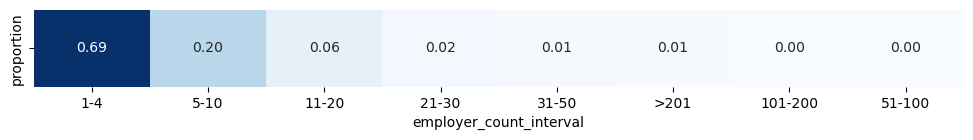

In [40]:
fig, ax = plt.subplots(figsize = (12, 1))
sns.heatmap(companies_c.employer_count_interval.value_counts(normalize=True).to_frame().T,\
            annot=True, fmt='.2f', cmap='Blues', cbar=False);

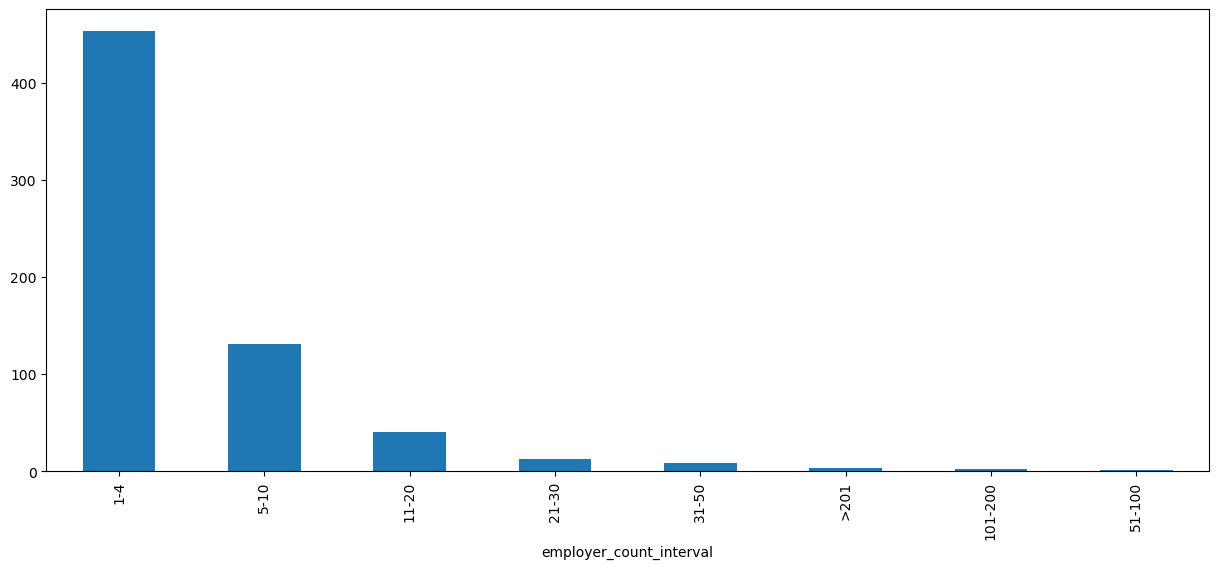

In [41]:
companies_c.employer_count_interval.value_counts().plot.bar();

из представленных компаний:  
70% - это небольшие компании до 5 человек,  
20% от 5 до 10 человек

In [42]:
billing_c.sort_values(['company_id','created_at']).head(1)

,id,user_id,company_id,billing_tariff_id,payed_until,is_payed,created_at,updated_at,billing_tariff_price_id,comment,pay_date,billing_tariff,created_y
780,380,1,1,3,2020-11-29,True,2019-07-23,2020-07-25,9,NaN,NaT,профи,2019


In [43]:
billing_c.query('is_payed==True').groupby('company_id').id.agg('count').describe()

count   656.00
mean      1.47
std       1.53
min       1.00
25%       1.00
50%       1.00
75%       1.00
max      17.00
Name: id, dtype: float64

Видно, что в большей массе компании оплачивают только один счет.
Однако счет может быть на месяц и более. 
Гектаро проводит стимулирование клиентов на покупку подписки от года и делает хорошую скидку.

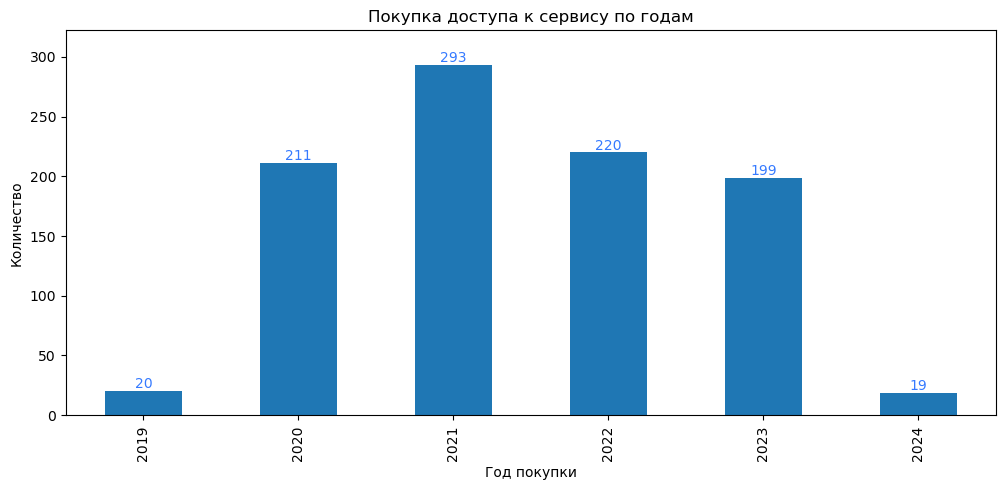

In [44]:
#покупка доступа в сервис по месяцам
fig, ax = plt.subplots(figsize = (12, 5))
ax = billing_c.query('is_payed==True').groupby(billing_c.created_at.dt.to_period("y")).company_id.count().plot.bar()

ax.bar_label(ax.containers[0], label_type='edge', color=lcolors[0])
ax.margins(y=0.1)
ax.set(xlabel='Год покупки', ylabel='Количество',title='Покупка доступа к сервису по годам');

Если смотреть компании, которые точно оплатили счет, то активнее всего покупки были в 2021 году.  
Возможно это связано с проводимыми маркетинговыми акциями или повышением спроса в строительной сфере.

### Популярность тарифов

In [45]:
#определим какя доля компаний продливала подписку или верулась чтобы еще раз поработать в срвисе
((len(billing_c.query('is_payed==True')
      .groupby('company_id').user_id.count().reset_index().query('user_id>1'))/billing_c.company_id.nunique())*100)

19.054878048780488

В основном из представленных компании покупали одну подписку - это 80%  
Однако, 20% продливали подписку или возвращалис повторно что работать в сервисе

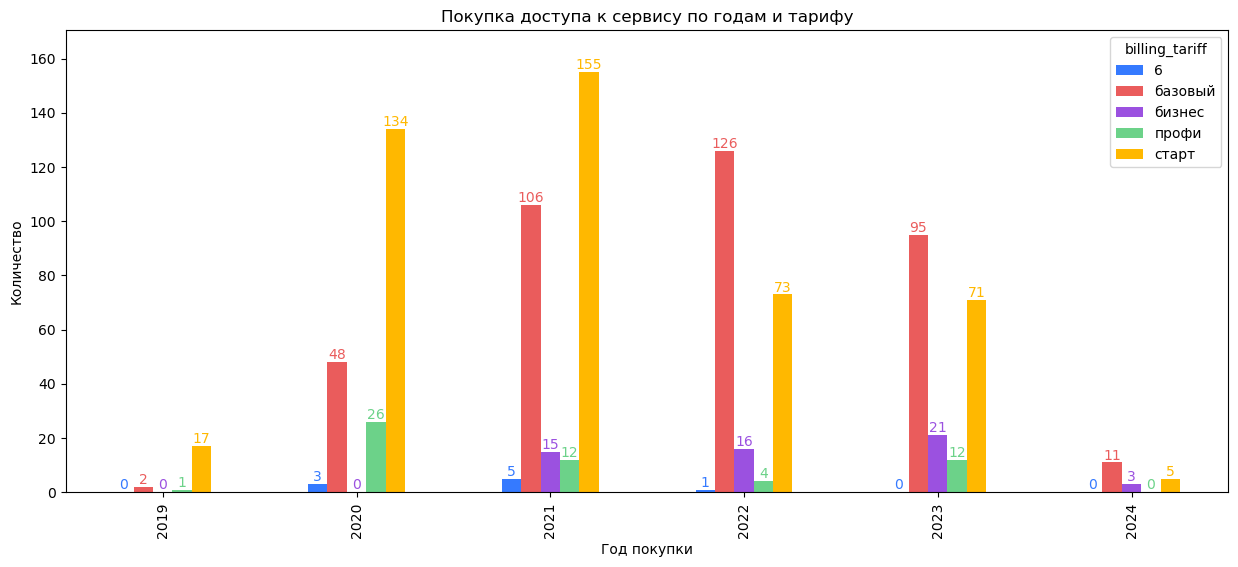

In [46]:
#тарифы которые покупали пользователи по годам
ax = billing_c.query('is_payed==True')\
    .pivot_table(index='created_y', columns = 'billing_tariff', values ='user_id', aggfunc='count')\
    .plot.bar(color=lcolors)

for i in range(5):
    ax.bar_label(ax.containers[i], label_type='edge', color=lcolors[i])
    ax.margins(y=0.1)

ax.set(xlabel='Год покупки', ylabel='Количество',
        title='Покупка доступа к сервису по годам и тарифу');

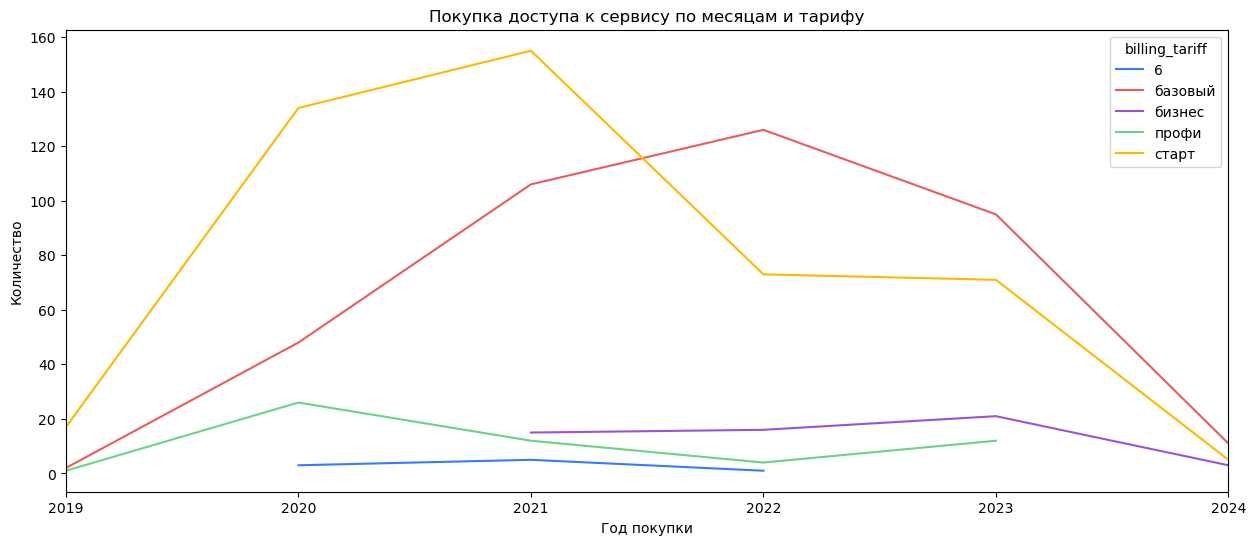

In [47]:
#визуализируем для наглядности еще и линейный график 
ax=billing_c.query('is_payed==True')\
    .pivot_table(index='created_y', columns = 'billing_tariff', values ='user_id', aggfunc='count')\
    .plot(color=lcolors)
ax.set(xlabel='Год покупки', ylabel='Количество',
        title='Покупка доступа к сервису по месяцам и тарифу');

в 2019 году начались продажи(учет) доступа к сервису  
В 21-22 года отмечается пик количества покупок тарифов старт и базовый.   
Интересная закономерность, что сначала лидируют тариф старт, затем базовый.    
Вполне возможно, что клиенты приходили с одного тарифа на другой. Или продлевали.

Посмотрим какие тарифы покупают новые клиенты, без учта продлния подписок.

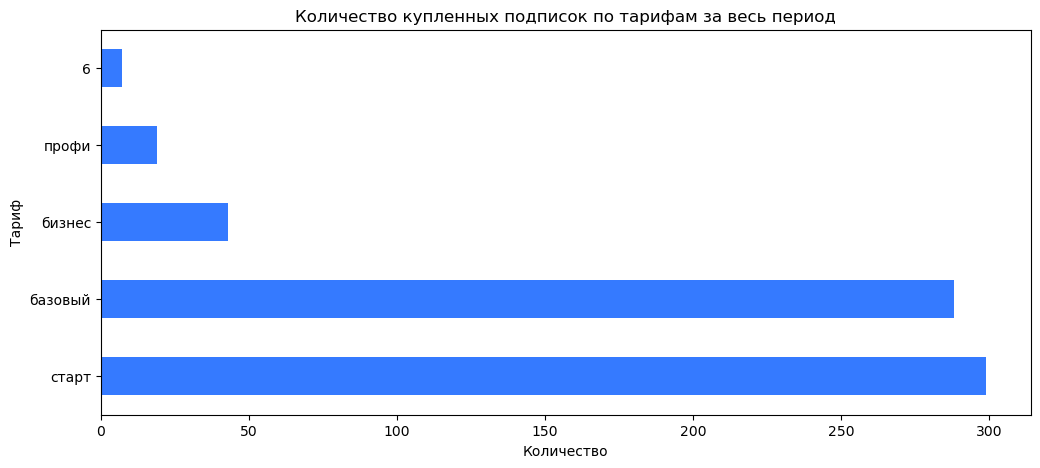

In [48]:
fig, ax = plt.subplots(figsize = (12, 5))
(billing_c.query('is_payed==True').sort_values(['company_id', 'created_at'])
 .groupby('company_id').agg(frst_tariff=('billing_tariff','first')).reset_index()
 .frst_tariff.value_counts().plot.barh(color=lcolors[0]));

ax.set(xlabel='Количество', ylabel='Тариф',
        title='Количество купленных подписок по тарифам за весь период');

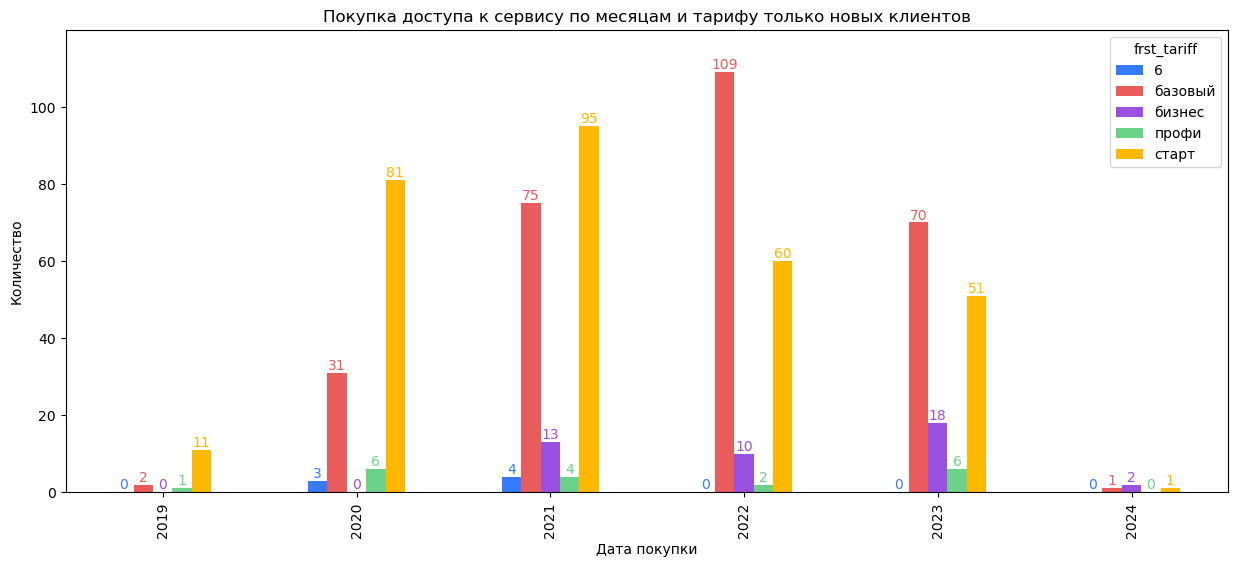

In [49]:
ax = (billing_c.query('is_payed==True').sort_values(['company_id', 'created_at'])
 .groupby('company_id').agg(frst_cr=('created_y','first'),frst_tariff=('billing_tariff','first')).reset_index()
 .pivot_table(index='frst_cr', columns='frst_tariff', values='company_id', aggfunc='count')).plot.bar(color=lcolors)

for i in range(5):
    ax.bar_label(ax.containers[i], label_type='edge', color=lcolors[i])
    ax.margins(y=0.1)
ax.set(xlabel='Дата покупки', ylabel='Количество',
        title='Покупка доступа к сервису по месяцам и тарифу только новых клиентов');

Даные график демонстрирует количество тарифов, которые покупали новые клиенты(с чего начинали свой путь в работе с сервисом)
Если в 2021 году траифы базовый и старт покупали практически одинаковое количество, то в 2022 базовго тарифа купили практичски в 2 раза больше.

В качестве базового варианта целевой переменной предлагается смотреть на наиболее позднее значение поля payed_until для компании и сравнивать его с “сегодняшней датой” (для унификации результатов - за сегодняшнюю дату принимаем дату начала проекта 28.03.2024). Если payed_until больше, чем сегодняшняя дата - компания может считаться действующим клиентом.

In [50]:
#определим статус клиента компании
df_clients = ((billing_c.groupby('company_id')['payed_until'].max()>=pd.to_datetime('2024-03-28'))
             .reset_index().rename(columns={'payed_until':'client'}))

billing_c = pd.merge(billing_c, df_clients, on="company_id", how='left')
billing_c.head(1)

,id,user_id,company_id,billing_tariff_id,payed_until,is_payed,created_at,updated_at,billing_tariff_price_id,comment,pay_date,billing_tariff,created_y,client
0,3050,567,512,3,2021-12-22,False,2020-12-22,2020-12-22,12,NaN,NaT,профи,2020,True


In [51]:
print('количество компаний:', len(df_clients))

количество компаний: 656


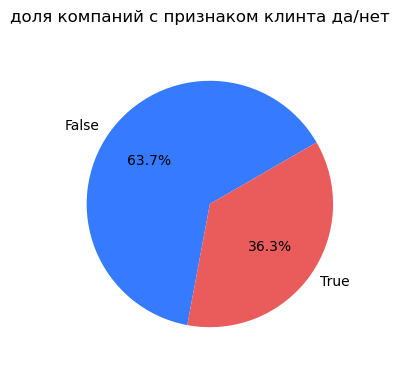

In [52]:
fig, ax = plt.subplots(figsize = (8, 4))
billing_c.client.value_counts().plot.pie(autopct = '%1.1f%%', startangle=30, colors=lcolors)
plt.ylabel(None)
plt.suptitle('доля компаний с признаком клинта да/нет'+ '\n', fontsize=12);

В данных больше компаний, которые перестали быть клиентами, практически 64%  
36% - это действующие клиенты   

### Смена тарифов

In [53]:
#определим первую дату покупки и тариф, который был куплен
d1 =(billing_c.query('is_payed==True').sort_values(['company_id', 'created_at'])
  .groupby('company_id').agg(frst_cr=('created_at','min'), frst_tariff=('billing_tariff','first')))
#определим последнюю дату покупки и тариф
d2 = (billing_c.sort_values(['company_id', 'created_at'])
  .groupby('company_id').agg(last_cr=('created_at','max'), last_tariff=('billing_tariff','last')))
#обьедеим данные 
d3 = d1.join(d2)
#менял ли клиент тариф
d3['chage_tariff'] = d3.frst_tariff!=d3.last_tariff
#менялся ли тариф на начала использования полписки и дальше
d3['combined'] = d3[['frst_tariff','last_tariff']].values.tolist()
#добавляю статус клинта 
d3 = d3.join(df_clients.set_index("company_id"))

In [54]:
d3.head()

,frst_cr,frst_tariff,last_cr,last_tariff,chage_tariff,combined,client
company_id,,,,,,,
1,2019-07-23,профи,2020-04-21,профи,False,"[профи, профи]",False
21,2020-01-28,старт,2023-01-12,старт,False,"[старт, старт]",False
30,2019-10-17,старт,2021-06-23,старт,False,"[старт, старт]",False
108,2020-04-27,6,2022-11-28,базовый,True,"[6, базовый]",False
116,2020-07-14,старт,2021-07-27,старт,False,"[старт, старт]",False


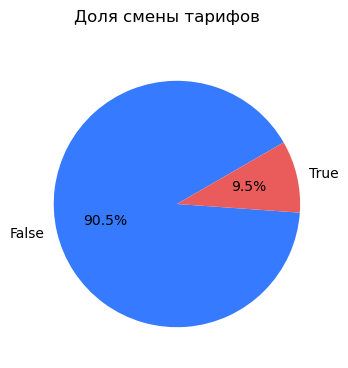

In [55]:
fig, ax = plt.subplots(figsize = (8, 4))
d3.chage_tariff.value_counts().plot.pie(autopct = '%1.1f%%', startangle=30, colors=lcolors)
plt.ylabel(None)
plt.suptitle('Доля смены тарифов'+ '\n', fontsize=12);

- 90% компаний не остались на момент выгрузки с тем тарифом, который оплатили первый раз
- 10% компаний сменили тариф

Большая часть компаний в представленных данных не меняла тариф

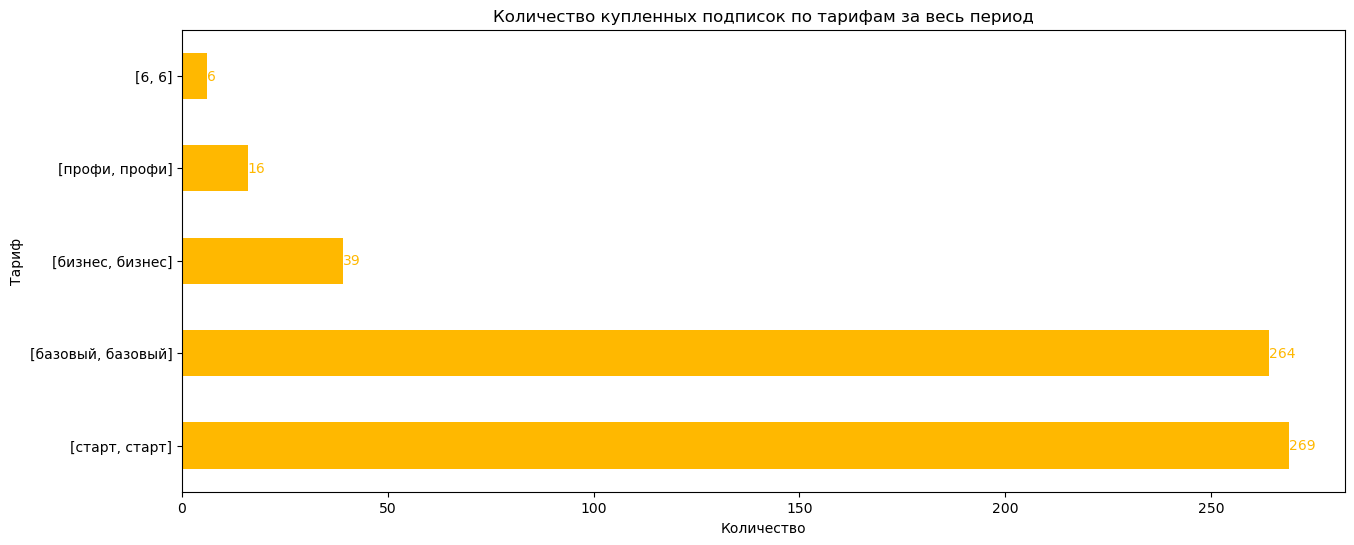

In [56]:
ax = d3.query('chage_tariff == False').combined.value_counts().head().plot.barh(color=lcolors[4])
ax.bar_label(ax.containers[0], label_type='edge', color=lcolors[4])

ax.set(xlabel='Количество', ylabel='Тариф',
        title='Количество купленных подписок по тарифам за весь период');

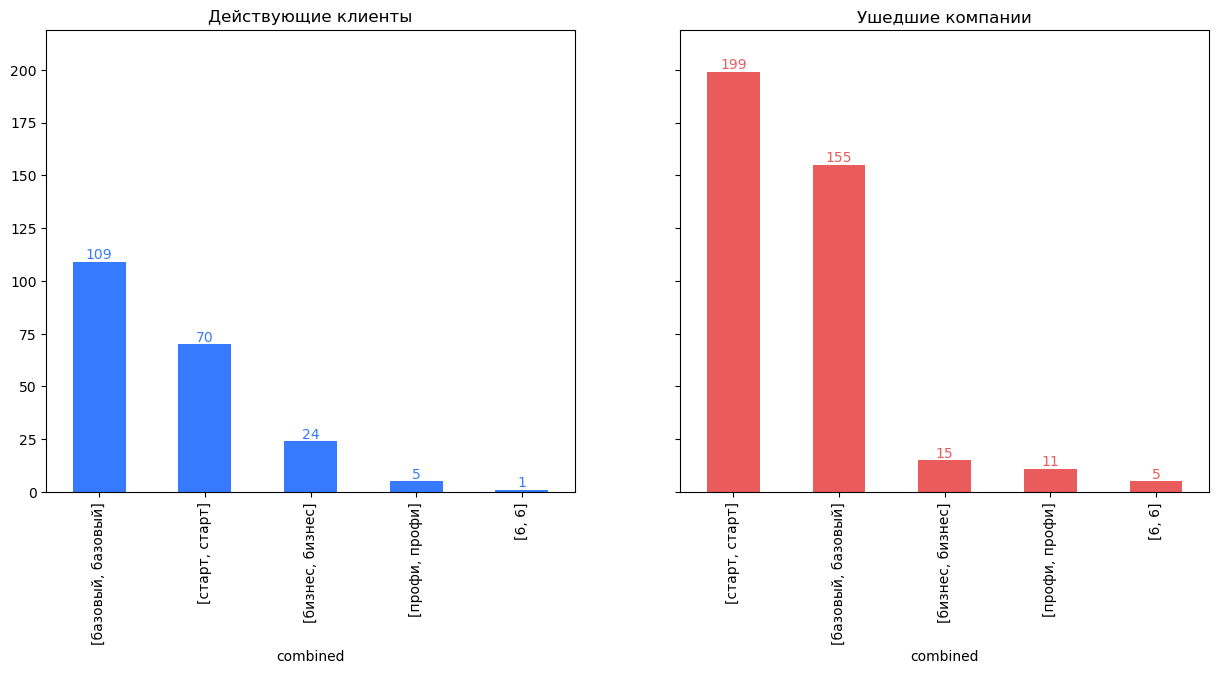

In [57]:
# 5 наиболее часто встречающихся данных о тарифе
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
plt.subplot(1, 2, 2)
ax1 = d3.query('client==False and chage_tariff == False').combined.value_counts().head().plot.bar(color=lcolors[1])
ax1.bar_label(ax1.containers[0], label_type='edge', color=lcolors[1])
ax1.margins(y=0.1)
plt.title('Ушедшие компании')
plt.subplot(1, 2, 1)
ax2 =d3.query('client==True and chage_tariff == False').combined.value_counts().head().plot.bar(color=lcolors[0])
ax2.bar_label(ax2.containers[0], label_type='edge', color=lcolors[0])
ax2.margins(y=0.1)
plt.title('Действующие клиенты');

Компании, которые на данный момент являются клиентами чаще используют тариф базовый, старт, бизнес.
Компании, которые уже не являются чаще выбирали старт и базовый, а также меняли старт на базовый 

In [58]:
#посмотримна то, как компании меняли свой тариф с момента оплаты до послдней записи
df = d3.query('chage_tariff==True').combined.value_counts().reset_index()
df.head()

,combined,count
0,"[старт, базовый]",28
1,"[базовый, старт]",17
2,"[базовый, бизнес]",5
3,"[бизнес, старт]",3
4,"[базовый, профи]",2


In [59]:
#данные о действующих клиентах
df_clnt = d3.query('chage_tariff==True and client == True')
df_clnt_lbls = d3.query('chage_tariff==True and client == True').combined.value_counts().reset_index()
#данные о ушедших клинтах
df_nclnt = d3.query('chage_tariff==True and client == False')
df_nclnt_lbls = d3.query('chage_tariff==True and client == False').combined.value_counts().reset_index()

In [60]:
def con_tariff(df, df_lbls):
    G = nx.Graph()
    #импортируем данные (create_using=nx.DiGraph() 2-хсторонние связи)
    G = nx.from_pandas_edgelist(df, 'frst_tariff', 'last_tariff', create_using=nx.DiGraph())
    #подписи для связей
    edge_labels = {}
    for index, row in df_lbls.iterrows():
        edge_labels[tuple(row['combined'])] = str(row['count'])
    #считаем число вершин, чтобы выбрать число цветов
    nodes = len(G.nodes())

    pos = nx.circular_layout(G)
    #опции для граней и вершин
    options = {
        'node_color': lcolors[:nodes],
        'node_size': 2900,
        'width': 1,
        'arrowstyle': '-|>',
        'arrowsize': 16}
    #рисуем отображние
    nx.draw(G, pos=pos, with_labels = True, arrows=True, **options, connectionstyle='arc3, rad = 0.1')
    #наносим числа
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels,  label_pos=0.3)

    ax = plt.gca()
    ax.collections[0].set_edgecolor("#000000")

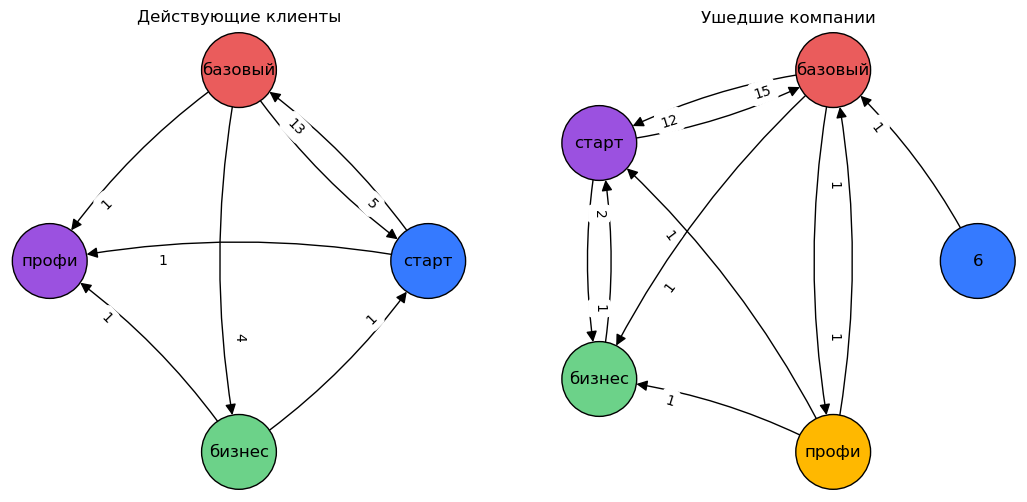

In [61]:
#визуализируем данные
plt.figure(figsize=(13, 6))
plt.subplot(1, 2, 2)
con_tariff(df_nclnt, df_nclnt_lbls)
plt.title('Ушедшие компании')

plt.subplot(1, 2, 1)
con_tariff(df_clnt, df_clnt_lbls)
plt.title('Действующие клиенты');

Среди действующих клиентов, был переход с тарифа старт на базовый (13 компаний). Значительно меньше среди действующих клиентов было понижение тарифа (5 компаний). А также с базового тарифа перешли на бизнес 4 компании 

Среди ушедших клиентов переходы между стартом и базовым практически 

Вся проблема, что мы не понимаем до какого периода оплачена подписка:
1. вариант клиент мог сформировать счет и не оплатить его
2. клиент оплатил счет, но потом несколько раз менял тариф или менял условия, которые сформировали дополнительные строки в билинге

тут тоже возможны ошибки, так как последняя запись н всегда отражат фатическое положение дел. Возможно, в файле с компаниями тарифуказыватся на момет выгрузки финальный. Но опять это догладки.

### Активность работы клиентов в сервисе

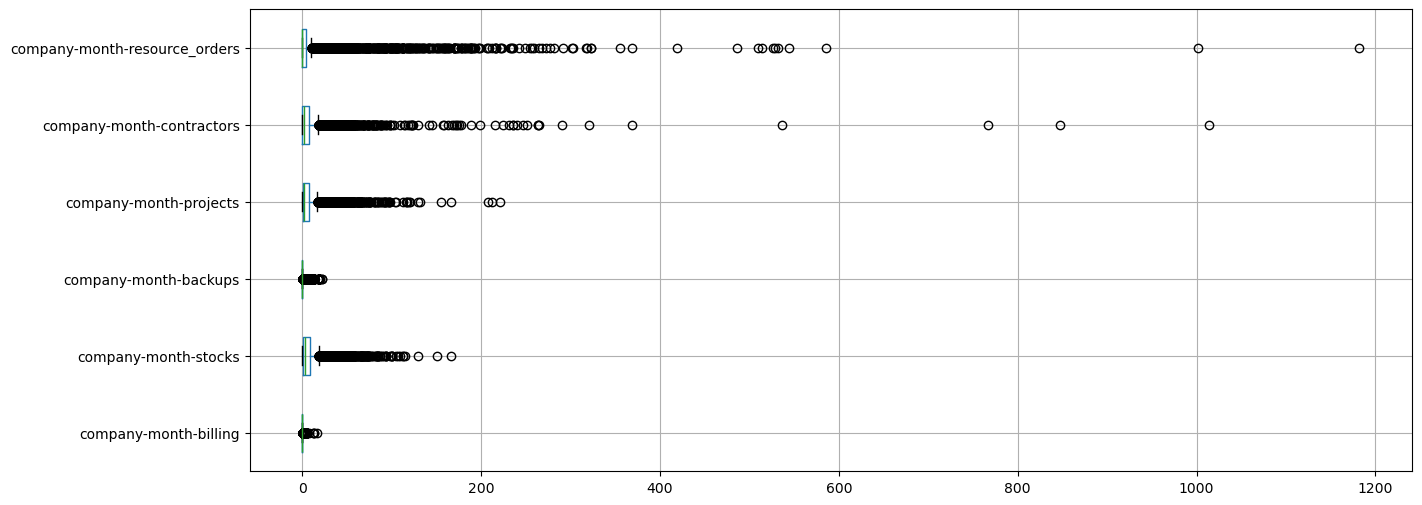

In [62]:
#посмотрим на активность компаий в сервисе
activities_c.drop(columns=['company_id']).boxplot(vert=False);

In [63]:
activities_c.drop(columns=['company_id', 'month']).describe()

,company-month-billing,company-month-stocks,company-month-backups,company-month-projects,company-month-contractors,company-month-resource_orders
count,"6,013.00","6,013.00","6,013.00","6,013.00","6,013.00","6,013.00"
mean,0.37,7.37,1.21,7.22,7.95,10.63
std,0.81,13.10,3.17,13.89,28.30,41.44
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,1.00,0.00,1.00,0.00,0.00
50%,0.00,3.00,0.00,2.00,2.00,0.00
75%,0.00,8.00,0.00,7.00,7.00,4.00
max,16.00,166.00,22.00,221.00,"1,014.00","1,182.00"


В данных очень много выбросов, так как присутствует компании, которые осуществляют разную деятельность.  
Ремонт и строительство домов различаются масштабами по числу операций(счета, количество проектов, контрагенты)

Так же в данных есть компании, которые решили только попробовать работать с сервисом и компании, которые работают а протяжении длительного времени.

**В среднем прихоится на 1 месяц работы в срвисе:**
- 2 проекта
- 2 контрагента
- 3 склада  

функциональность резервного копирования клиенты мало пользовались.
И мало вели учет количества заказов материалов

In [64]:
#соберем данные по компаниям
act = (activities_c.groupby('company_id').agg(billing_sum =('company-month-billing', 'sum'),
                                     stocks_sum =('company-month-stocks', 'sum'),
                                     projects =('company-month-projects', 'sum'), 
                                     projects_m =('company-month-projects', 'mean'),
                                     contractors =('company-month-contractors', 'sum'), 
                                     orders =('company-month-resource_orders', 'sum'), 
                                     month_min = ('month', 'min'), 
                                     month_max = ('month', 'max'),
                                     months_cnt = ('month', 'count')))

#act['months_delta'] = ((act.month_max - act.month_min).dt.days//30)+1
# так считать нельзя!!!!

act.head()

,billing_sum,stocks_sum,projects,projects_m,contractors,orders,month_min,month_max,months_cnt
company_id,,,,,,,,,
1,7,59,57,2.71,22,0,2019-01-01,2020-11-01,21
21,21,84,83,3.46,127,15,2019-05-01,2023-05-01,24
30,11,62,61,2.54,142,0,2019-01-01,2021-11-01,24
108,4,10,10,1.67,21,0,2019-05-01,2022-12-01,6
116,5,52,50,2.63,61,69,2019-02-01,2021-11-01,19


In [65]:
#from dateutil.relativedelta import relativedelta
# Функция для вычисления разницы в месяцах между датами
def months_between_dates(date1, date2):
    delta = relativedelta(date1, date2)
    months_diff = delta.years * 12 + delta.months
    return months_diff+1 #+1 чтобы учесть первый месяц, в котором тоже работала компания 

# Применение функции для каждой строки DataFrame
act['months_between'] = act.apply(lambda row: months_between_dates(row['month_max'], row['month_min']), axis=1)

# количество месяцев, между возможно оплаченным и фактически отработаным  
act['freeze'] = (act.months_between-act.months_cnt)

act.head()

,billing_sum,stocks_sum,projects,projects_m,contractors,orders,month_min,month_max,months_cnt,months_between,freeze
company_id,,,,,,,,,,,
1,7,59,57,2.71,22,0,2019-01-01,2020-11-01,21,23,2
21,21,84,83,3.46,127,15,2019-05-01,2023-05-01,24,49,25
30,11,62,61,2.54,142,0,2019-01-01,2021-11-01,24,35,11
108,4,10,10,1.67,21,0,2019-05-01,2022-12-01,6,44,38
116,5,52,50,2.63,61,69,2019-02-01,2021-11-01,19,34,15


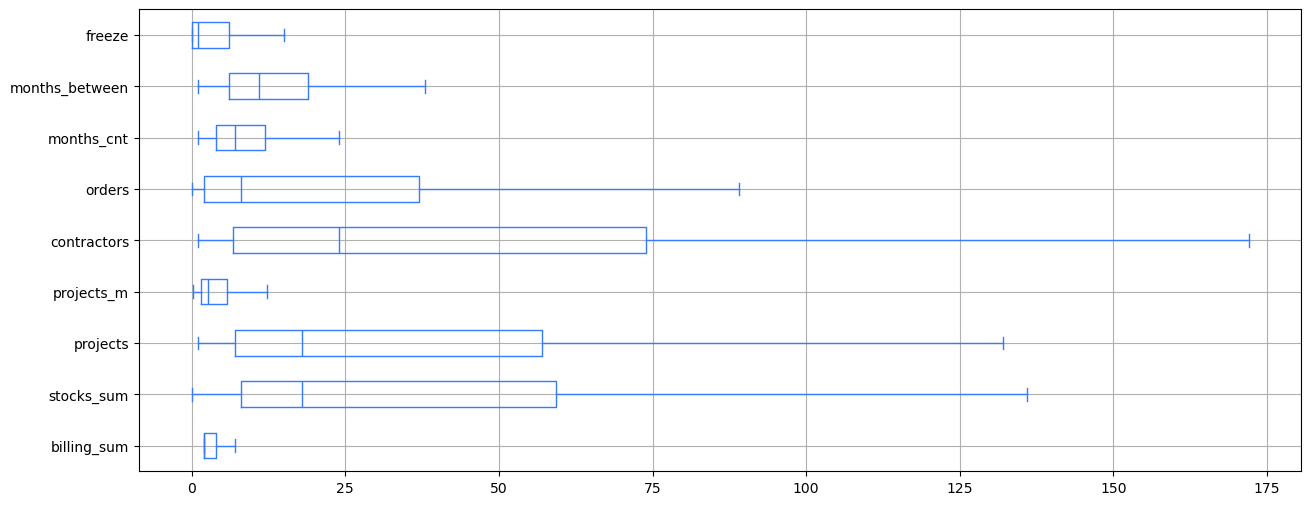

In [66]:
act.boxplot(vert=False, showfliers=False, color=lcolors[0]);

In [67]:
act.drop(columns =['month_min', 'month_max']).describe()

,billing_sum,stocks_sum,projects,projects_m,contractors,orders,months_cnt,months_between,freeze
count,656.00,656.00,656.00,656.00,656.00,656.00,656.00,656.00,656.00
mean,3.37,67.51,66.17,5.25,72.88,97.43,9.17,13.64,4.48
std,2.82,166.23,165.63,7.18,143.09,472.21,7.39,10.24,7.10
min,2.00,0.00,1.00,0.20,1.00,0.00,1.00,1.00,0.00
25%,2.00,8.00,7.00,1.50,6.75,2.00,4.00,6.00,0.00
50%,2.00,18.00,18.00,2.67,24.00,8.00,7.00,11.00,1.00
75%,4.00,59.25,57.00,5.80,74.00,37.00,12.00,19.00,6.00
max,29.00,"2,122.00","2,121.00",62.38,"1,343.00","9,420.00",46.00,53.00,47.00


**В среднем приходится на компанию:**
    
- 16 проектов
- 22 контрагента
- 18 складов
- 9 месяцев работы в сервисе

месяцы, которые пропущены у компании это возможно заморозка, у компании в эти месяцы нет проектов или она не была клиентом.
Хорошо если в  учете, если компания месяц не работала, но подписка есть, то в этих месяцах были бы 0.
Я видел в данных нули у некоторых компаний, но тут не понято, это сами клиенты честно проставляли или автоматически.

В данных присутствуют и действующие клиенты и бывшие.
Объединим данные двух таблиц

In [68]:
#добавляем признак клиента
act = act.join(df_clients.set_index('company_id'))
#обогадим данными о тарифе и количестве сотрудников
act = act.join(companies.set_index('id')[['employer_count_interval', 'billing_tariff']])

In [69]:
act.head()

,billing_sum,stocks_sum,projects,projects_m,contractors,orders,month_min,month_max,months_cnt,months_between,freeze,client,employer_count_interval,billing_tariff
company_id,,,,,,,,,,,,,,
1,7,59,57,2.71,22,0,2019-01-01,2020-11-01,21,23,2,False,11-20,профи
21,21,84,83,3.46,127,15,2019-05-01,2023-05-01,24,49,25,False,1-4,старт
30,11,62,61,2.54,142,0,2019-01-01,2021-11-01,24,35,11,False,1-4,старт
108,4,10,10,1.67,21,0,2019-05-01,2022-12-01,6,44,38,False,5-10,базовый
116,5,52,50,2.63,61,69,2019-02-01,2021-11-01,19,34,15,False,1-4,старт


In [70]:
#проверим компании которые не являются клиентами, но продолжали работу в 2024-03
act.query('client==False and month_max>="2024-03-01"').sort_values('month_max')

,billing_sum,stocks_sum,projects,projects_m,contractors,orders,month_min,month_max,months_cnt,months_between,freeze,client,employer_count_interval,billing_tariff
company_id,,,,,,,,,,,,,,
1640,3,33,30,2.50,36,10,2020-08-01,2024-03-01,12,44,32,False,5-10,базовый
6256,3,38,37,3.70,33,11,2022-06-01,2024-03-01,10,22,12,False,1-4,старт


In [71]:
#список id, у которых доступ должен прекратиться в апреле
list_id = act.query('client==False and month_max>="2024-03-01"').sort_values('month_max').index

#проверка
billing[billing.company_id.isin(list_id)]

,id,user_id,company_id,billing_tariff_id,payed_until,is_payed,created_at,updated_at,billing_tariff_price_id,comment,pay_date,billing_tariff,created_y
418,4714,1897,1640,7,2023-07-08,False,2021-07-08,2021-07-08,34,NaN,2021-07-12,старт,2021
1173,8970,1897,1640,2,2023-10-26,True,2022-07-25,2022-07-26,8,"26,07,22 - активация, 12+3",2022-07-26,базовый,2022
2456,8711,8158,6256,7,2024-03-07,True,2022-06-21,2024-03-04,26,"1,07 ,22- активация 18+2",2022-06-28,старт,2022
2462,8777,8158,6256,7,2022-06-29,False,2022-06-29,2022-06-29,26,NaN,2022-06-29,старт,2022


Компания с ID 1640, согласно данным билинга должна была прекратить работу 2023-10-26. Данные в комментариях это подтверждают, однако, мы видим что по данным активности работы компаний в сервисе компания еще продолжала работу в марте 2024

Компания с ID 6256 действительно должна была прекратить работу в 2024-03-07. И ситуация по текущим данным выглядит правдопобно.

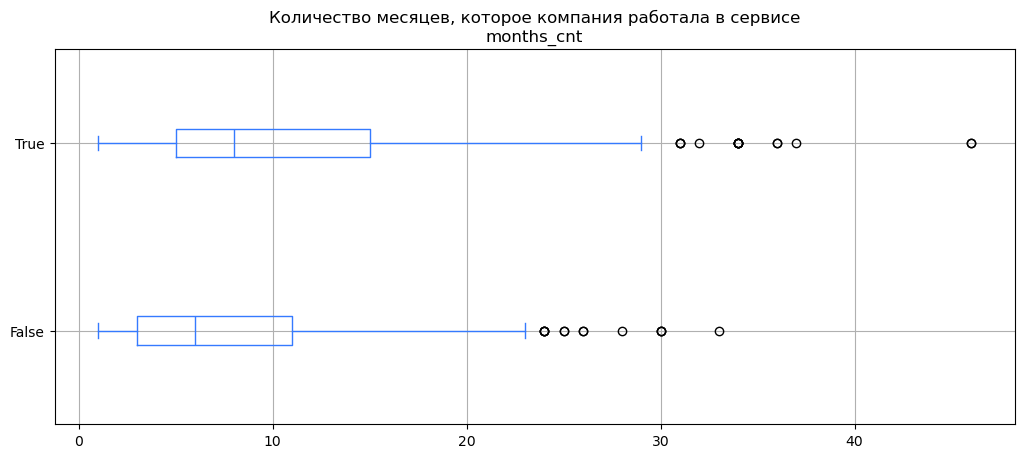

In [72]:
#количество меcяцев, которые компании работали в сервисе в разбивкой действующий/прошлый клиент 
fig, ax = plt.subplots(figsize = (12, 5))
act.boxplot(column=['months_cnt'], by='client',vert=False, color=lcolors[0], ax=ax)
plt.suptitle('Количество месяцев, которое компания работала в сервисе', fontsize=12)
plt.ylabel(None);

In [73]:
act.pivot(values='months_cnt', columns ='client').describe()

client,False,True
count,421.00,235.00
mean,7.90,11.44
std,6.15,8.78
min,1.00,1.00
25%,3.00,5.00
50%,6.00,8.00
75%,11.00,15.00
max,33.00,46.00


Медианное среднее количества работы в месяцах в сервисе, у прошлых клиентов меньше, чем у действующих и равно 6.  
Медианное среднее у действующих клиентов равно 8.

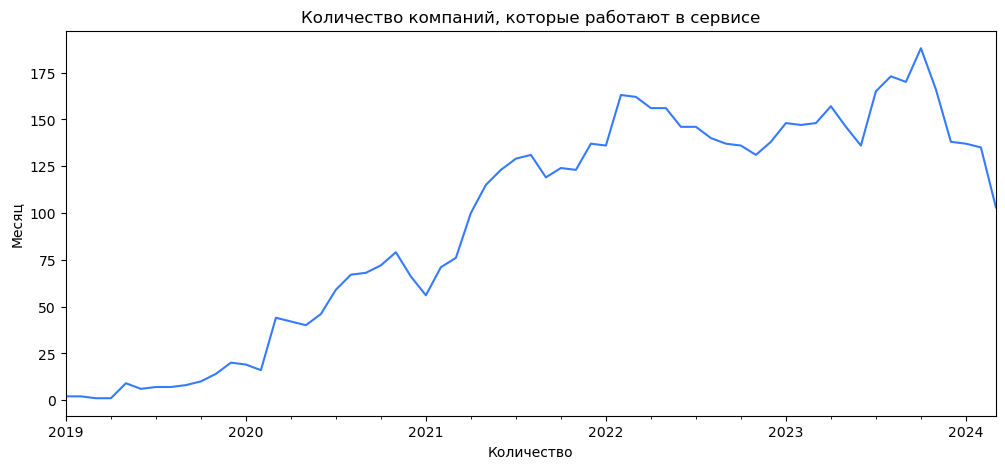

In [74]:
#активность работы компаний в сервисе по месяцам
fig, ax = plt.subplots(figsize = (12, 5))
activities_c.groupby(activities_c.month.dt.to_period("m")).company_id.count().plot(color=lcolors[0])
ax.set(xlabel='Количество', ylabel='Месяц',
        title='Количество компаний, которые работают в сервисе');

График иллюстрирут рост число компаний, которые работают каждый месяц в срвисе. По позрастающй линии можно сказать, что число коипаний, которые работают ежемесячно возрастает

In [75]:
activities_c = (activities_c.set_index('company_id').join(df_clients.set_index('company_id'))).reset_index()

<Axes: xlabel='month'>

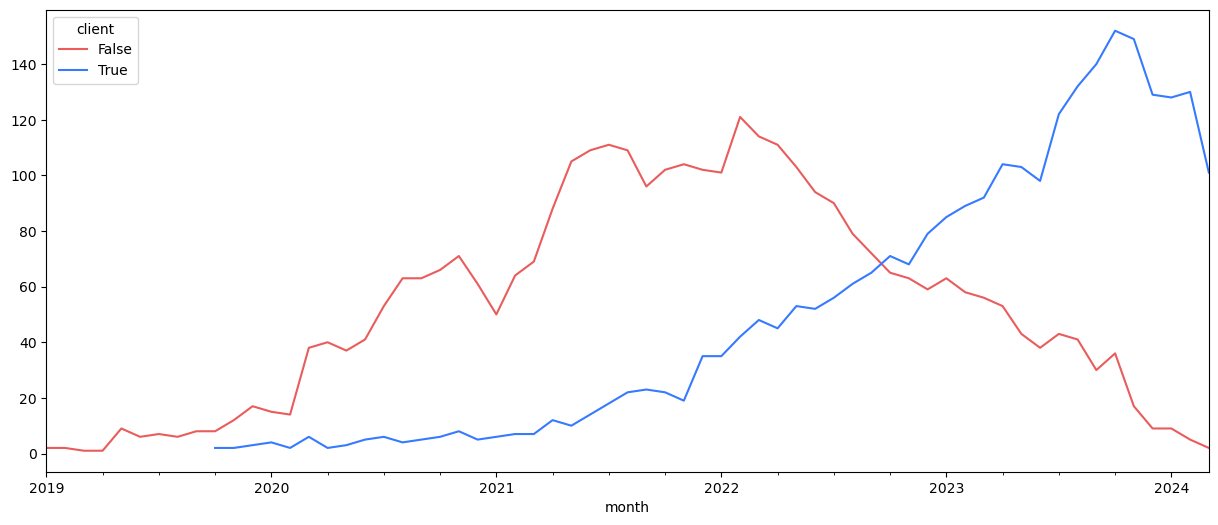

In [76]:
(activities_c.pivot_table(index=activities_c.month.dt.to_period("m"), columns='client', values='company_id', aggfunc='count').plot(color=list(reversed(lcolors[:2]))))

График иллюстрирует, разделение клиентов на действующих и ушедших.
Действующих на конец периода увеличивается, это хороший знак.
Однако с конца 23 года наблюдается снижение.
Посмотрим на отток

In [77]:
def years_between_dates(date1, date2):
    delta = relativedelta(date1, date2)
    months_diff = delta.years 
    return months_diff+1 #+1 чтобы учесть первый месяц, в котором тоже работала компания 

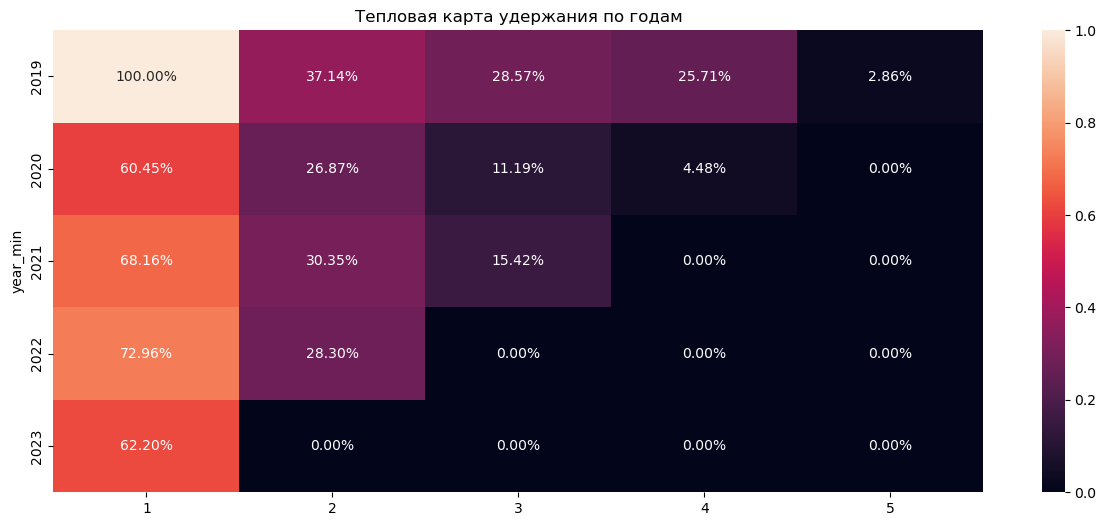

In [78]:
result_raw = activities_c.merge(act.reset_index()[['company_id','month_min']], on='company_id', how='left')
result_raw['year_min'] = result_raw.month_min.dt.year
result_raw['year'] = result_raw.month.dt.year
result_raw['lifetime'] = (result_raw['year'] - result_raw['year_min'])
result_grouped = result_raw.pivot_table(index=['year_min'], columns='lifetime', values='company_id', aggfunc='nunique')
cohort_sizes = (result_raw.groupby('year_min').agg({'company_id': 'nunique'}).rename(columns={'company_id': 'cohort_size'}))
result_grouped = cohort_sizes.merge(result_grouped, on='year_min', how='left').fillna(0)
result_grouped = result_grouped.div(result_grouped['cohort_size'], axis=0).drop(columns=['cohort_size'])
sns.heatmap(result_grouped.drop(columns=[0]), annot=True, fmt='.2%',)
plt.title('Тепловая карта удержания по годам');

In [79]:
cohort_sizes.merge(result_grouped.drop(columns=[0]), on='year_min', how='left').fillna(0)

,cohort_size,1,2,3,4,5
year_min,,,,,,
2019,35,1.00,0.37,0.29,0.26,0.03
2020,134,0.60,0.27,0.11,0.04,0.00
2021,201,0.68,0.30,0.15,0.00,0.00
2022,159,0.73,0.28,0.00,0.00,0.00
2023,127,0.62,0.00,0.00,0.00,0.00


Хороший коэффициент отскока может быть за счет того, что выгоднее всего покупать доступ к сервису на год.
На второй год коэффициент сильно падает.
Когорта 2019 года возможно имела хорошие преимущества, возможно более выгодные финансовые предложения.

In [80]:
act.groupby(act.month_min.dt.to_period("y")).agg(companies = ('billing_sum','count'), clients  = ('client','sum'))

,companies,clients
month_min,,
2019,35,4
2020,134,7
2021,201,47
2022,159,69
2023,127,108


Однако,если смотреть на данные о признка клиента, видно что из 127 компании, которые пришли в 2023 году, на дату составления выгрузки 127 остаются клиентами. 

In [81]:
act.query('"2023-12-01" >= month_min >="2023-01-01" and client==True and month_max>="2024"')

,billing_sum,stocks_sum,projects,projects_m,contractors,orders,month_min,month_max,months_cnt,months_between,freeze,client,employer_count_interval,billing_tariff
company_id,,,,,,,,,,,,,,
7123,4,93,91,6.50,134,21,2023-01-01,2024-02-01,14,14,0,True,1-4,старт
7142,2,20,19,1.73,30,55,2023-01-01,2024-03-01,11,15,4,True,1-4,базовый
7163,4,12,12,0.92,376,9,2023-01-01,2024-01-01,13,13,0,True,1-4,базовый
7211,5,55,55,3.93,1076,1902,2023-01-01,2024-03-01,14,15,1,True,31-50,старт
7269,4,89,87,7.25,8,21,2023-01-01,2024-03-01,12,15,3,True,1-4,профи
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9402,2,12,12,2.40,7,6,2023-11-01,2024-03-01,5,5,0,True,1-4,старт
9457,3,68,64,12.80,48,280,2023-11-01,2024-03-01,5,5,0,True,21-30,профи
9471,2,67,18,4.50,3,12,2023-11-01,2024-02-01,4,4,0,True,5-10,бизнес


Однако, не все работают в сервис, только 78 из 128

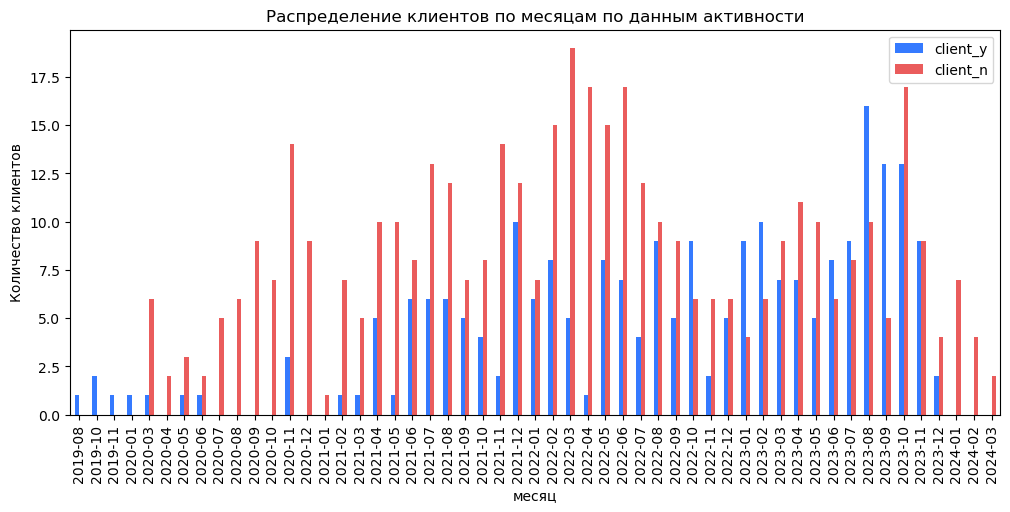

In [82]:
#клиенты, которые до сих пор остаются клинтами. месяц начала работы в сервисе
d1=act.query('client==True').groupby(act.month_min.dt.to_period("M")).client.count().to_frame()
#клиенты, которые перстали быть клинтами. месяц окончания использования 
d2=act.query('client==False').groupby(act.month_max.dt.to_period("M")).client.count().to_frame()
#для графика делаем общий индекс дат и убираем дубликаты 
ds=pd.concat([d1,d2]).reset_index()['index'].drop_duplicates().to_frame()
#собираем все в один дата сет и визуализируем 
ds = ds.set_index('index').join(d1, how='left', rsuffix='_y')
ds = ds.join(d2, how='left', rsuffix='_n')
ds = ds.rename(columns = {'client':'client_y'}).sort_index()
fig, ax = plt.subplots(figsize = (12, 5))
ds.plot.bar(color=lcolors, ax=ax)
ax.set(xlabel='месяц', ylabel='Количество клиентов', title='Распределение клиентов по месяцам по данным активности');

Отчетливо видно, когда пришли клиенты, которые до сих пор работают в сервисе.
Также видны месяцы, когда был максимальный отток.
В 2024 году еще не пришли новые клиенты, только действующие

In [83]:
#проверка что в 24 году новых клиентов небыло, были оплаты существующих
#clnts2024 = billing_c.query('created_at >= "2024" and is_payed==True').company_id.tolist()
#billing_c.query('created_at >= "2024" and is_payed==True').head()
#activities_c.query('company_id in @clnts2024').head()
#act.reset_index().query('company_id == 1088')

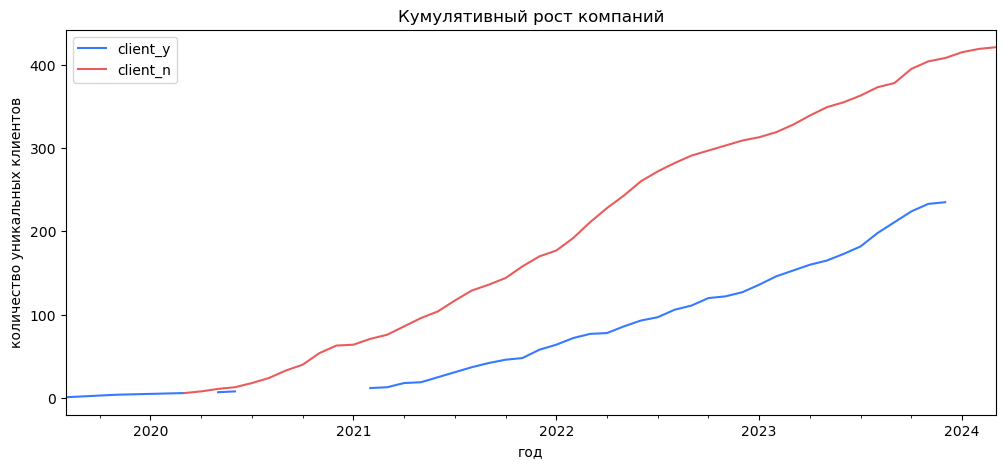

In [84]:
#кумулятивный рост клиентов, которые перестали работать в прогрмме и которые продолжают
fig, ax = plt.subplots(figsize = (12, 5))
ds.cumsum().plot(color=lcolors, ax=ax)
ax.set(xlabel='год', ylabel='количество уникальных клиентов', title='Кумулятивный рост компаний');

График хорошо иллюстрирует что в 2020 году есть обравы, так как в этот год пришло мало клиентов. Это вероятнее всего связно с ковидом. Максимальная неопреденность и новые комп. 
В 2024 не пришли новые клинеты. Это уж вот странно. 

In [85]:
#подготовим данные для анализа. 
#отберем данные с оплатами. определим что первая дата в created_at дата это дата начала, когда компания стала клиентом
# последняя запись в payed_until - дата окончания работы с сервисом, а для действующих будущая дата окончания
d=(billing_c.sort_values(['company_id', 'created_at'])
 .groupby('company_id').agg(frst_cr=('created_at','min'),
                            last_pay=('payed_until','max'),
                            frst_tariff=('billing_tariff','first'),
                            last_tariff=('billing_tariff','last')))
#определим количство дней работы с сервисом 
d['total_days'] = (d.last_pay-d.frst_cr).dt.days


In [86]:
d = pd.merge(d, df_clients, on="company_id", how='left')

в данные попадают действуюшие контракты, которые учитывают будущий период. Это не позволят опредлить какой средний приодиспользования сервисом. Необходимо добавить дату горизонта и определить является ли действующим клинтом компания

In [87]:
#сколько дней является клиентом
d.loc[d['client']==True, 'total_days'] = (pd.to_datetime('2024-03-28') - d.query('client==True').frst_cr).dt.days

In [88]:
d.isna().sum()

company_id     0
frst_cr        0
last_pay       0
frst_tariff    0
last_tariff    0
total_days     0
client         0
dtype: int64

In [89]:
d.reset_index().query('company_id==495')

,index,company_id,frst_cr,last_pay,frst_tariff,last_tariff,total_days,client
22,22,495,2019-12-09,2024-09-01,базовый,базовый,1571,True


<Axes: >

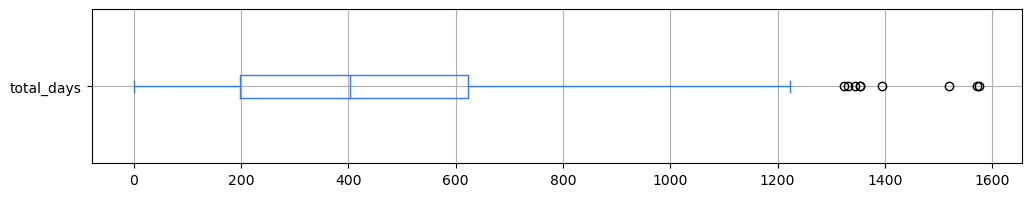

In [90]:
fig, ax = plt.subplots(figsize = (12, 2))
d.boxplot(column=['total_days'], vert=False, color=lcolors[0])

In [91]:
d.total_days.describe()

count     656.00
mean      450.33
std       287.47
min         0.00
25%       198.00
50%       403.00
75%       622.00
max     1,576.00
Name: total_days, dtype: float64

Медиана и среднее около 365 дней. Покупают доступ на год 
Это полностью соответствует тому, что условия получения скидки на использования, только при годовой покупке доступа. 
Минимальные значения отрицательные, посмотрим их позже.

<Axes: title={'center': 'total_days'}, ylabel='client'>

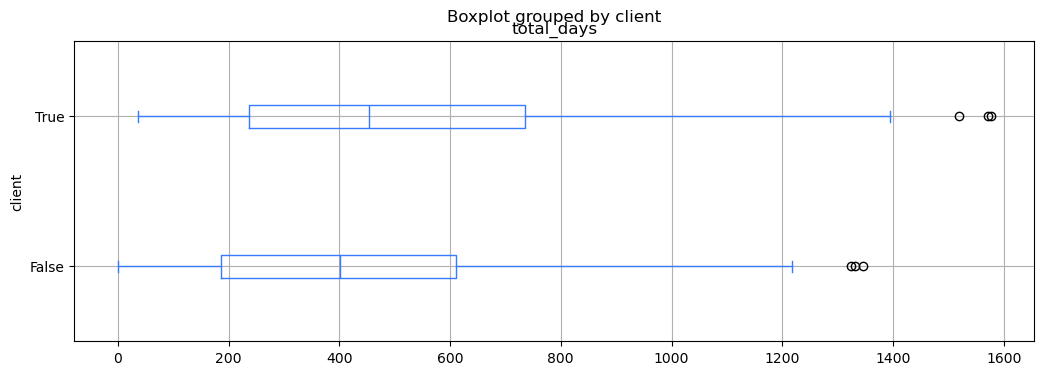

In [92]:
fig, ax = plt.subplots(figsize = (12, 4))
d.boxplot(column=['total_days'], by='client',vert=False, color=lcolors[0], ax=ax)

In [93]:
d.pivot(values='total_days', columns ='client').describe()

client,False,True
count,421.00,235.00
mean,420.14,504.41
std,269.54,310.38
min,0.00,36.00
25%,186.00,237.00
50%,401.00,454.00
75%,611.00,735.00
max,"1,345.00","1,576.00"


Среднее медианное 401 и 454, среди компаний клинтов и ушедших.
Если брать отбор по is_pay==True, то будет 365, это ще раз доказывает что большинство покупают на год.

In [94]:
#посмотрим на компаниий котрые работали 10 и менее дней
smd_list = d.query('total_days<=10').company_id.tolist()
cols =['company_id','payed_until','created_at','comment']
billing_c.query('company_id in @smd_list').sort_values(['company_id', 'created_at'])[cols]

,company_id,payed_until,created_at,comment
494,1154,2020-05-26,2020-05-26,"26,05 - оплатили, но Василий сообщил, что будет другой владелец регистрироваться на платформе, доступ по 02,06,21 заморозили"
166,2282,2021-03-24,2021-03-19,"24,03 - оплата 17800, первая часть\r\nактивировали на другую почту 1202236@mail.ru, внедрением занимается Светлана"
689,2348,2020-12-03,2020-12-02,требуется активировать на другого сотрудника основной аккаунт
74,2670,2021-01-27,2021-01-26,"27,01 - деактивация пакета, нужно будет активировать после регистрации на почту alekseymohov@gmail.com"
1153,3227,2022-11-14,2022-11-11,"18+2, не на ту почту активировали нужно на agent-pv01@yandex.ru"
964,4407,2022-04-04,2022-03-28,"18+2\r\nперенос оплаченного пакета на другую почту ceo2@dh-ural.ru (было до 01,12,2023)"
1210,7159,2023-01-31,2023-01-23,"30,01 - активация 12+1"


Видно что минимальные значения - это ошибочные действия, которые совершили пользователи компаний.
Минимум среди клинтов компании обсусловлен тем, что компании стали недавно клинтами и работат с сервисом только 26 дней.

Однако видно, что срок работы в сервисе у дйствубщих клиентов и бывших одличатся мало.

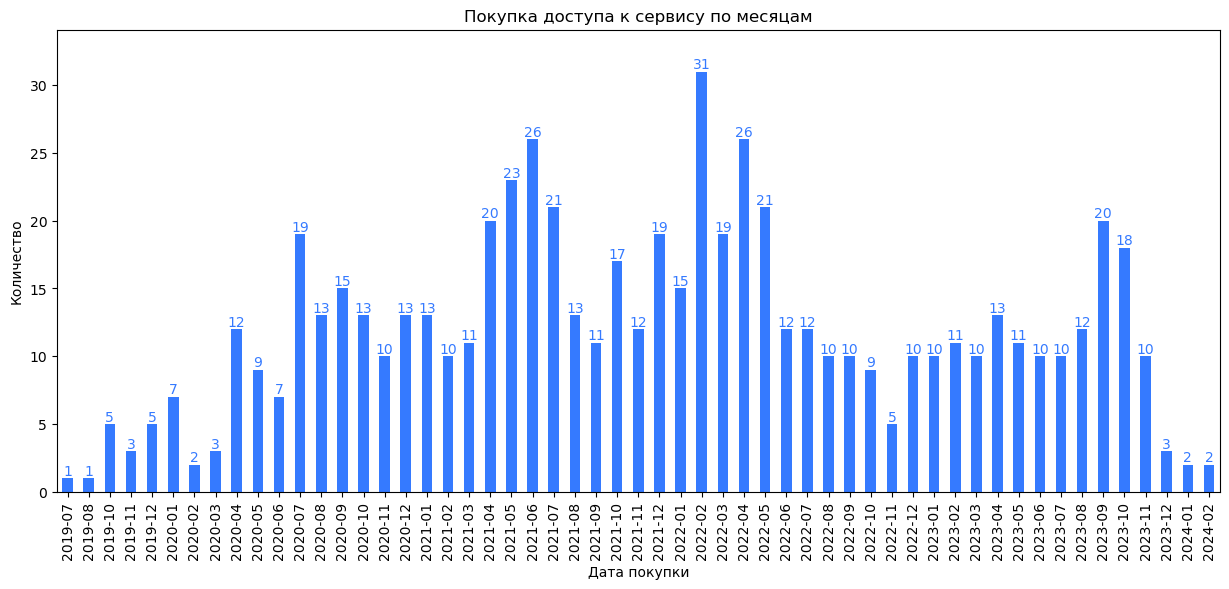

In [95]:
#покупка подписки по месяцам 
ax = d.groupby(d.frst_cr.dt.to_period("m")).client.count().plot.bar(color=lcolors[0])

ax.bar_label(ax.containers[0], label_type='edge', color=lcolors[0])
ax.margins(y=0.1)
ax.set(xlabel='Дата покупки', ylabel='Количество',title='Покупка доступа к сервису по месяцам');

In [96]:
d.head()

,company_id,frst_cr,last_pay,frst_tariff,last_tariff,total_days,client
0,1,2019-07-23,2021-07-25,профи,профи,733,False
1,21,2020-01-26,2023-05-27,старт,старт,1217,False
2,30,2019-10-17,2021-09-24,старт,старт,708,False
3,108,2020-04-27,2022-12-05,старт,базовый,952,False
4,116,2020-01-27,2022-02-02,старт,старт,737,False


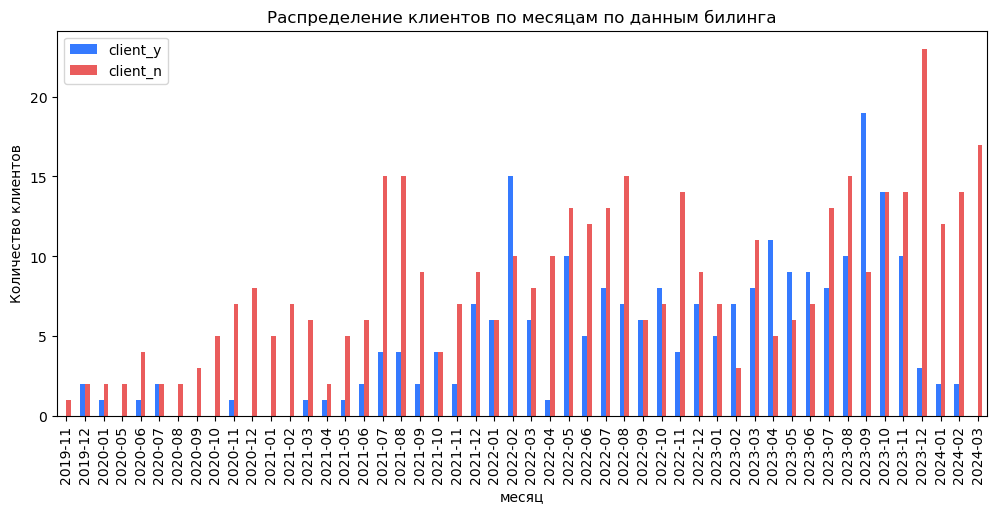

In [97]:
#клиенты, которые до сих пор остаются клинтами. месяц регистрации
d1 = d.query('client==True').groupby(d.query('client==True').frst_cr.dt.to_period("M")).client.count().to_frame()
#клиенты, которые перстали быть клинтами. месяц окончания использования 
d2 = d.query('client==False').groupby(d.query('client==False').last_pay.dt.to_period("M")).client.count().to_frame()
#для графика делаем общий индекс дат и убираем дубликаты 
d3=pd.concat([d1,d2]).reset_index()['index'].drop_duplicates().to_frame()
#собираем все в один дата сет и визуализируем 
d3 = d3.set_index('index').join(d1, how='left', rsuffix='_y')
d3 = d3.join(d2, how='left', rsuffix='_n')
d3 = d3.rename(columns = {'client':'client_y'}).sort_index()
fig, ax = plt.subplots(figsize = (12, 5))
d3.plot.bar(color=lcolors, ax=ax)
ax.set(xlabel='месяц', ylabel='Количество клиентов', title='Распределение клиентов по месяцам по данным билинга');

<Axes: xlabel='index'>

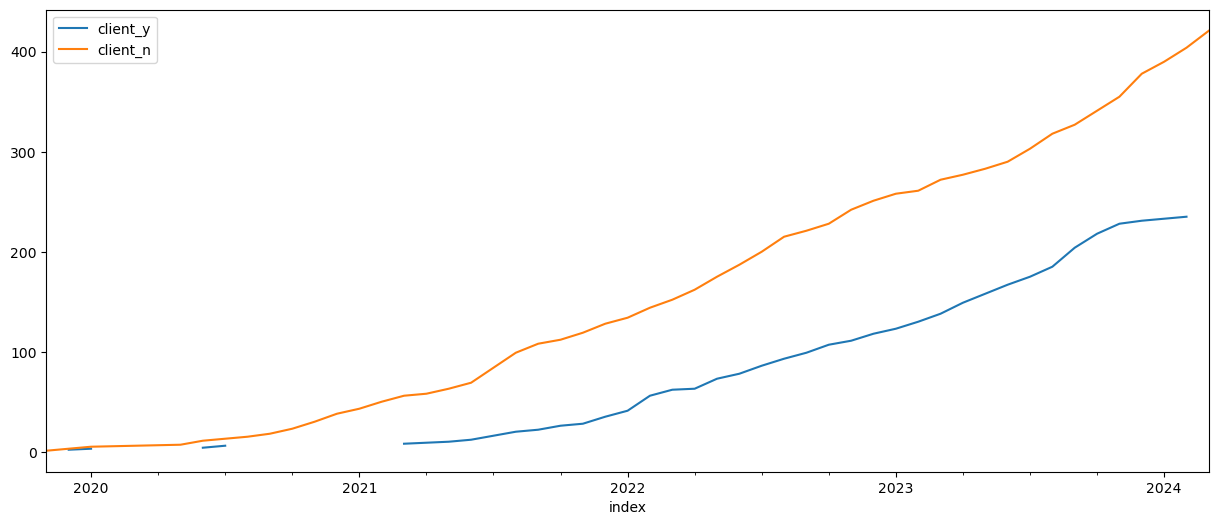

In [98]:
#кумулятивный рост 
d3.cumsum().plot()

In [99]:
d3.groupby(d3.index.strftime('%Y')).sum()

,client_y,client_n
index,,
2019,2.00,3
2020,5.00,35
2021,28.00,90
2022,83.00,123
2023,113.00,127
2024,4.00,43


С 2019 года и до момента выгрузки данных есть компании, которые до сих пор остаются клиентами.
Самый провальный год был 2020 возможно проводились неудачные маркетинговые акции. Хорошо если остается история, которую можно дополнительно изучить.
23-23 года являются самыми успешными с точки зрения удержания клиентов, с точки зрения оплаты.

### Пользователи

In [100]:
people.groupby('company_id').user_id.count().describe()

count   712.00
mean      5.36
std       5.49
min       1.00
25%       2.00
50%       3.00
75%       7.00
max      45.00
Name: user_id, dtype: float64

Минимальное количество 1 человек.  
Среднее медианное это 3 человека.  
Сервис разработан в основном для РП. Поэтому, предположительно будет полезен для тех кто ведет много проектов и хочет существенно экономить на программном обеспечении.

In [101]:
#добавим еще и количество сотрудников, которые могут работать с сервисом
act = act.join(people.groupby('company_id').user_id.count()).rename(columns ={'user_id':'users'})

In [102]:
act = act.join(activities_c.sort_values(by=['company_id', 'month']).groupby('company_id')['company-month-projects'].agg(list)).rename(columns ={'company-month-projects':'projects_list'})

In [103]:
#оставим для анализа только три послдних месяца
def last_3_pr(row):
   return row[-3:]   

In [104]:
#была идея проверить проекты увеличиваются или уменьшаются. На этом можно было посттроить предположния
act.loc[act['months_cnt']>=3, 'last_3_pr'] = act.query('months_cnt>=3').projects_list.apply(last_3_pr)

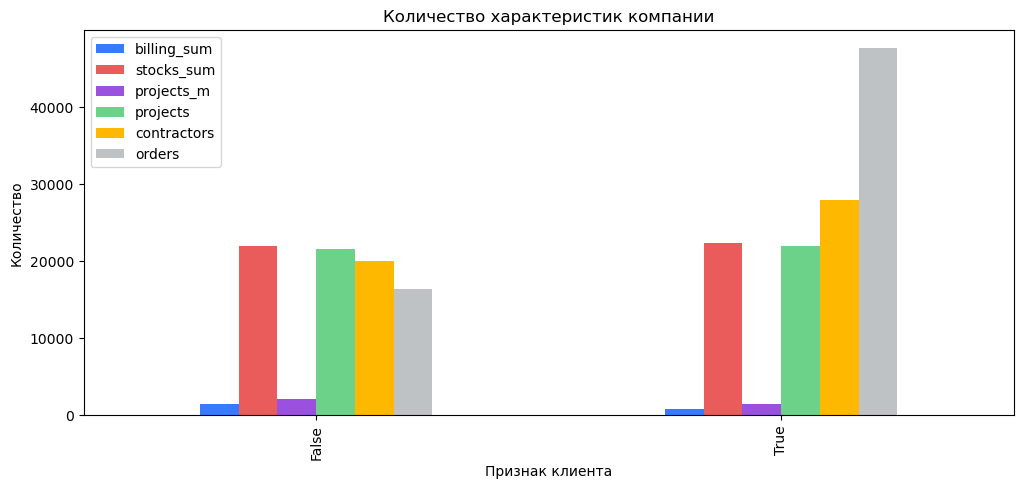

In [105]:
fig, ax = plt.subplots(figsize = (12, 5))
(act.groupby('client')[['billing_sum','stocks_sum', 'projects_m','projects','contractors', 'orders']]
 .agg('sum').plot.bar(color=lcolors, ax=ax))
ax.set(xlabel='Признак клиента', ylabel='Количество',
        title='Количество характеристик компании');

Видно, что суммарно активность по всем численным показателям выше у действующих клиентов.  
Особенно сильно выделяются месячное количество заказов материалов компании

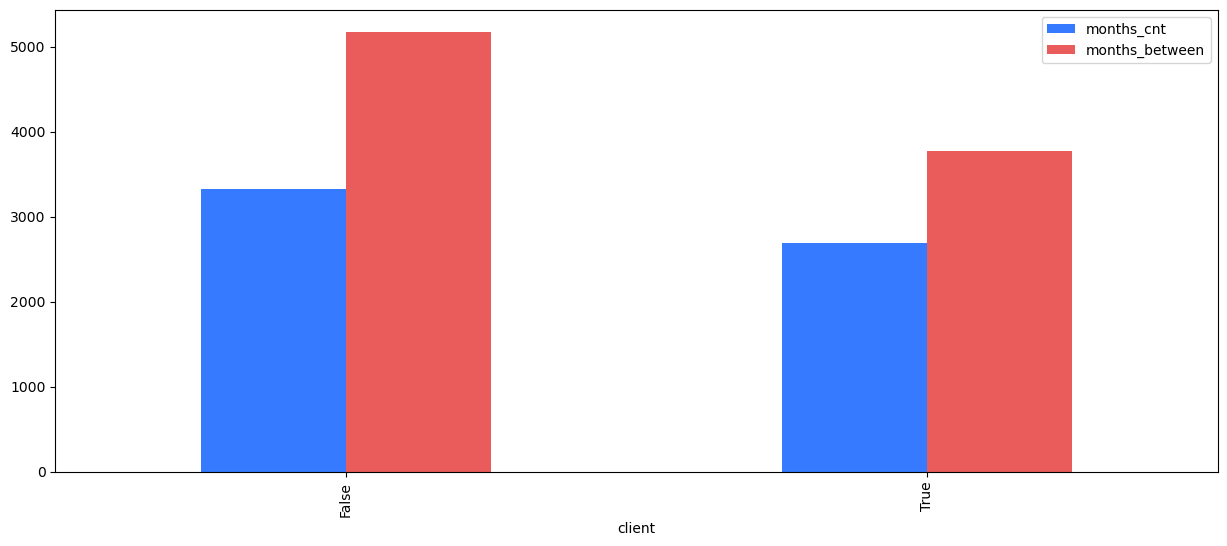

In [106]:
act.groupby('client')[['months_cnt','months_between']].agg('sum').plot.bar(color=lcolors)
ax.set(xlabel='Признак клиента', ylabel='Суммарное количество месяцев',
        title='Количество характеристик компании');

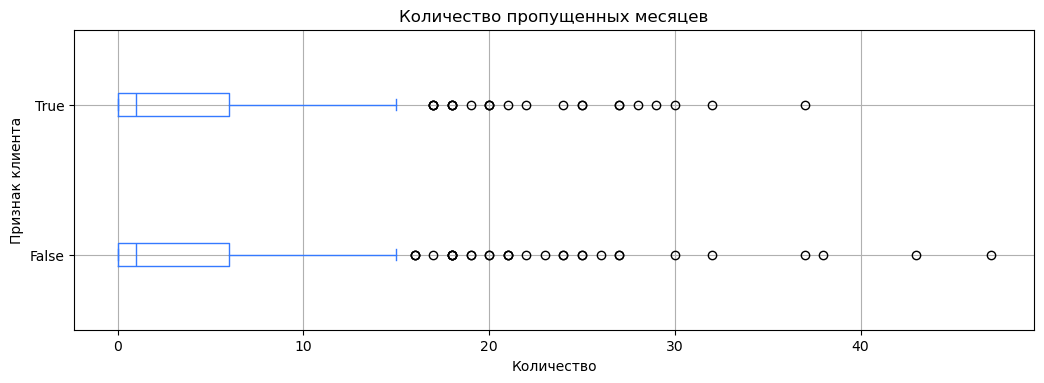

In [107]:
fig, ax = plt.subplots(figsize = (12, 4))
act.boxplot(column=['freeze'], by='client',vert=False, color=lcolors[0], ax=ax)
ax.set(xlabel='Количество', ylabel='Признак клиента',
        title='Количество пропущенных месяцев')
plt.suptitle(None);

In [108]:
act.pivot(values='freeze', columns ='client').describe()

client,False,True
count,421.00,235.00
mean,4.39,4.63
std,7.01,7.27
min,0.00,0.00
25%,0.00,0.00
50%,1.00,1.00
75%,6.00,6.00
max,47.00,37.00


В данных есть выбросы, но медианное среднее у групп одинаковое и равно нулю. 

<Axes: title={'center': 'users'}, ylabel='client'>

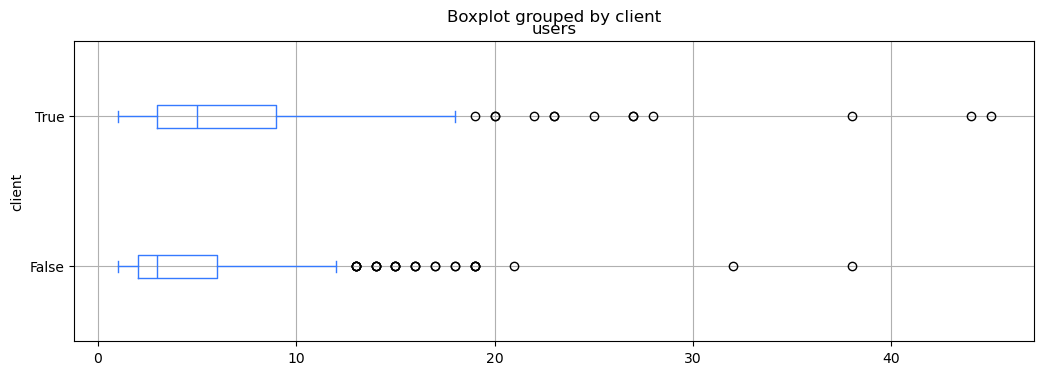

In [109]:
fig, ax = plt.subplots(figsize = (12, 4))
act.boxplot(column=['users'], by='client',vert=False, color=lcolors[0], ax=ax)

Количество пользователей, которые работают в сервисе в дейстующих клинтов больше.

[Text(0, 0.5, 'Количество'),
 Text(0.5, 0, 'Признак клиента'),
 Text(0.5, 1.0, 'Количество тарифов по прикнаку клиента')]

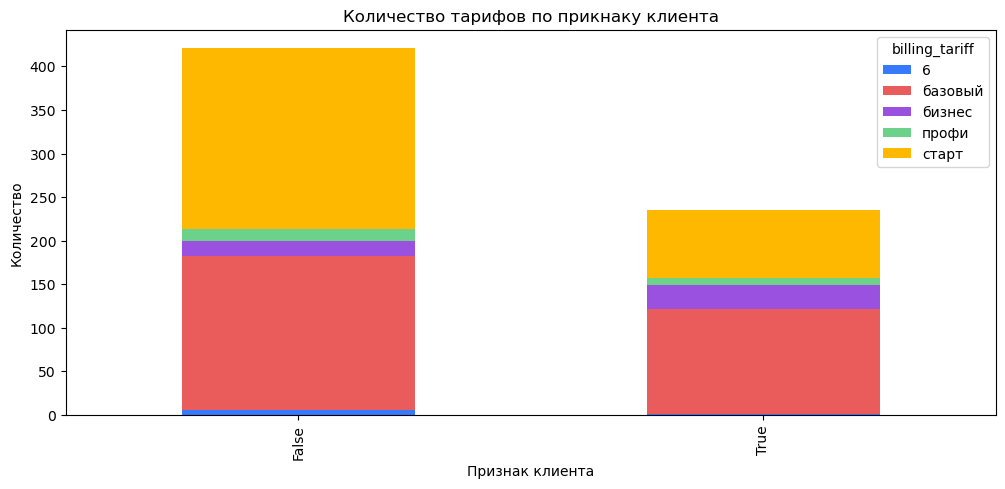

In [111]:
fig, ax = plt.subplots(figsize = (12, 5))
act.groupby(['client', 'billing_tariff']).billing_tariff.count().unstack().plot(kind='bar', color=lcolors, stacked=True, ax=ax)
ax.set(ylabel='Количество', xlabel='Признак клиента',
        title='Количество тарифов по прикнаку клиента');

In [112]:
#посмотрим коррляцию в данных
(act.drop(columns=['month_min','month_max','projects_list','last_3_pr', 'employer_count_interval', 'billing_tariff'])
 .corr(method='spearman').loc['client']).reset_index().sort_values('client')

,index,client
8,freeze,0.01
0,billing_sum,0.09
3,projects_m,0.14
7,months_between,0.18
10,users,0.20
2,projects,0.23
6,months_cnt,0.23
1,stocks_sum,0.23
4,contractors,0.26
5,orders,0.42


Их всех признаков видно, что признак климета связан только с количеством заказов материалов компании.
Суммарно количество проектов конечно хороший признак, но в данном случае неотимальный, так как его динамика во времени я вляется важной. Однако у нас нет четкой уверенности в данных. Поэтому на данном заканчиваю проект и пишу выводы

### Вывод

**Количество компаний в данном исследовании 656**

**Портрет компании:**
70% - это небольшие компании до 5 человек,
20% - от 5 до 10 человек
0.06% от 10 до 20 человек 

В основном из представленных компании покупали одну подписку - это 80%  
Однако, 20% продлевали подписку или возвращались повторно что работать в сервисе

**Популярные тарифы**
- старт      **299**
- базовый    **288**
- бизнес      **43**
- профи       **19**
- 6            **7**

Среди действующих клиентов тройка популярных тарифов:
базовый 109
старт 70
бизнес 24

Среди ушедших клиентов тройка популярных тарифов:
старт 199
базовый 155
бизнес 15

*Тариф сменили 10% от общего числа компаний*

Среди действующих клиентов, был переход с тарифа старт на базовый (13 компаний).  
Значительно меньше среди действующих клиентов было понижение тарифа (5 компаний).  
А также с базового тарифа перешли на бизнес 4 компании 

Среди ушедших клиентов переходы между стартом и базовым практически 

**В среднем приходится на 1 месяц работы в сервисе:**
- 2 проекта
- 2 контрагента
- 3 склада  

**В среднем приходится на 1 компанию:**
    
- 16 проектов
- 22 контрагента
- 18 складов
- 9 месяцев работы в сервисе

Медианное среднее количества работы в месяцах в сервисе, у прошлых клиентов меньше, чем у действующих и равно 6.
Медианное среднее у действующих клиентов равно 8.

Основные причины ухода обнаружены небыли. Однако существуют 2 очевидные причины:
- проблемы в бизнесе (косвенно это можно определить по уменьшающимся ежемесячным показателями, если компания действительно все заносит)
- недовольство функционалом, стоимостью сервиса.